In [1]:
from PIL import Image

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from __future__ import division, print_function
import sys

In [2]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    

In [4]:
class FCND(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

        self.gamma = nn.Parameter(data=torch.tensor([0.]))
        self.beta = nn.Parameter(data=torch.tensor([0.]))
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [5]:
def plot_result(i,x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(15,7))
    
    plt.plot(x,yh[:, 0], color="tab:red", linewidth=2, alpha=0.8, label="NN S")
    plt.plot(x,yh[:, 1], color="tab:green", linewidth=2, alpha=0.8, label="NN I")
    plt.plot(x,yh[:, 2], color="tab:blue", linewidth=2, alpha=0.8, label="NN R")
    plt.plot(x,y[:, 0], color="red", linewidth=2, alpha=0.8,linestyle='--',label="Exact S")
    plt.plot(x,y[:, 1], color="green", linewidth=2, alpha=0.8,linestyle='--',label="Exact I")
    plt.plot(x,y[:, 2], color="blue", linewidth=2, alpha=0.8,linestyle='--',label="Exact R")
    plt.scatter(x_data, y_data[:, 0], s=60, color="tab:red", alpha=0.4, label='Training S')
    plt.scatter(x_data, y_data[:, 1], s=60, color="tab:green", alpha=0.4, label='Training I')
    plt.scatter(x_data, y_data[:, 2], s=60, color="tab:blue", alpha=0.4, label='Training R')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Colloc. points')
    """l = plt.legend(loc=(0.701,0.14), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.text(1.665,1.3,"Step: %i"%(i+1),fontsize="xx-large",color="k")"""
    plt.title('SIR model, step %i'%(i+1),fontsize="xx-large")
    plt.ylabel('SIR',fontsize="xx-large")
    plt.xlabel('Time',fontsize="xx-large")
    plt.legend()
    plt.axis("on")
    plt.show()


In [6]:
def plot_result_al(i,x,y,x_data,y_data,yh,xp=None):
    fig = plt.figure(figsize=(15,10))

    ax1 = fig.add_subplot(212)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(221)


    ax1.plot(x,yh[:, 1], color="tab:green", linewidth=2, alpha=0.8, label="NN I")
    ax1.plot(x,y[:, 1], color="green", linewidth=2, alpha=0.8,linestyle='--',label="Exact I")
    ax1.scatter(x_data, y_data[:, 1], s=60, color="tab:green", alpha=0.4, label='Training I')
    ax1.set_xlabel("time")
    ax1.set_ylabel("Suseoptibles")
    ax1.legend()
    ax1.set_title('SIR model, step %i'%(i+1),fontsize="xx-large")

    ax2.plot(x,yh[:, 0], color="tab:red", linewidth=2, alpha=0.8, label="NN S")
    ax2.plot(x,y[:, 0], color="red", linewidth=2, alpha=0.8,linestyle='--',label="Exact S")
    ax2.scatter(x_data, y_data[:, 0], s=60, color="tab:red", alpha=0.4, label='Training S')
    ax2.set_xlabel("time")
    ax2.set_ylabel("Infectados")
    ax2.legend()
    ax2.set_title('SIR model, step %i'%(i+1),fontsize="xx-large")

    ax3.plot(x,yh[:, 2], color="tab:blue", linewidth=2, alpha=0.8, label="NN R")
    ax3.plot(x,y[:, 2], color="blue", linewidth=2, alpha=0.8,linestyle='--',label="Exact R")
    ax3.scatter(x_data, y_data[:, 2], s=60, color="tab:blue", alpha=0.4, label='Training R')
    ax3.set_xlabel("time")
    ax3.set_ylabel("Removidos")
    ax3.legend()
    ax3.set_title('SIR model, step %i'%(i+1),fontsize="xx-large")

    plt.show()

# Simulacion por Rk4 modelo SAIRD

torch.Size([200, 1]) torch.Size([200, 3])
torch.Size([10, 1]) torch.Size([10, 3])


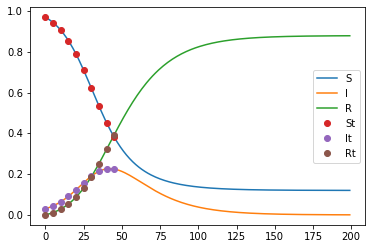

In [18]:
sim = pd.read_csv('./sim_SIR.csv')
N_old = sim['S'][0] + sim['I'][0] + sim['R'][0]
sim['S'] = sim['S'] / N_old
sim['I'] = sim['I'] / N_old
sim['R'] = sim['R'] / N_old

sim_t = torch.tensor(sim[['t']].values, dtype=torch.float32)
sim_data = torch.tensor(sim[['S', 'I', 'R']].values, dtype=torch.float32)

print(sim_t.shape, sim_data.shape)

sim_t_train = sim_t[:50:5]
sim_data_train = sim_data[:50:5]

print(sim_t_train.shape, sim_data_train.shape)

fig = plt.figure()
plt.plot(sim_t, sim_data, label=['S', 'I', 'R'])
plt.plot(sim_t_train, sim_data_train, 'o', label=['St', 'It', 'Rt'])
plt.legend();

### PINN con busqueda de parametros

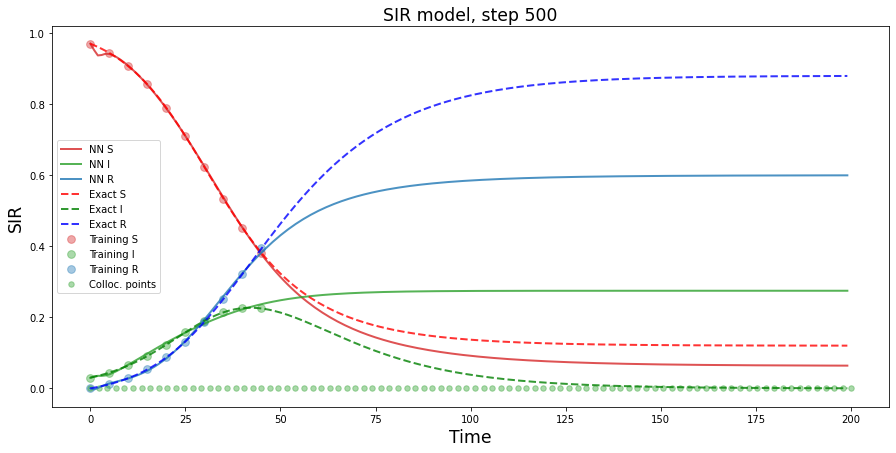

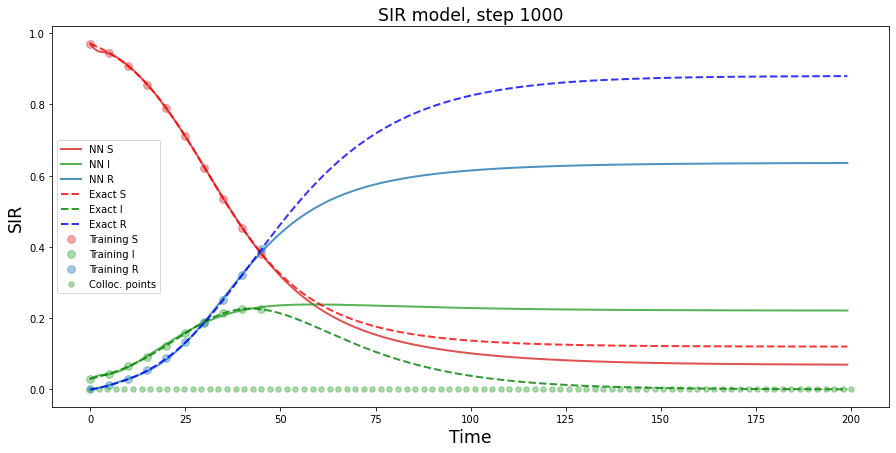

step = 1000 , loss1 = 8.823155e-06 , loss2 = 2.9774537e-05 , loss = 3.8597693e-05 , mse = 0.02057407 , beta = 0.106872514 , gamma = 0.014679535


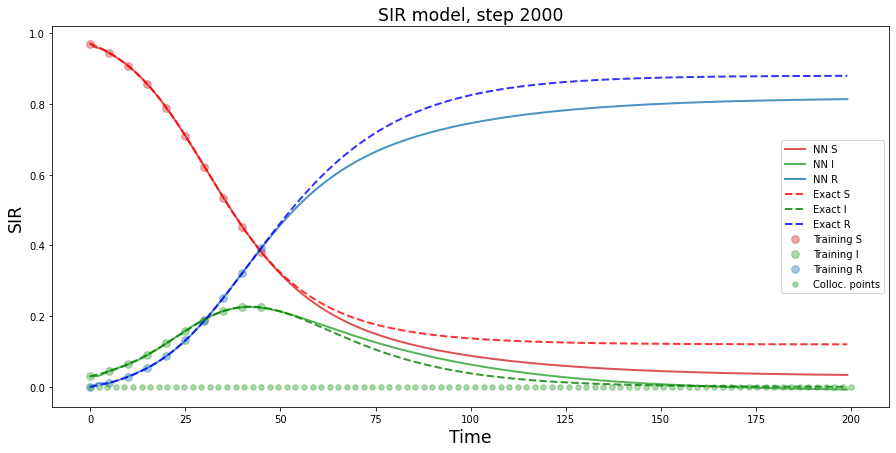

step = 2000 , loss1 = 5.708718e-07 , loss2 = 2.2387962e-06 , loss = 2.809668e-06 , mse = 0.0022130215 , beta = 0.14672314 , gamma = 0.056140076


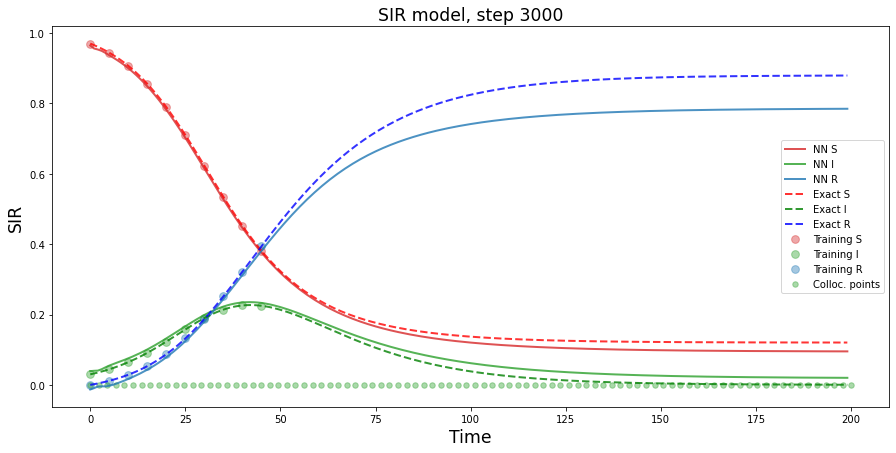

step = 3000 , loss1 = 0.00018406665 , loss2 = 2.314816e-06 , loss = 0.00018638147 , mse = 0.0019260378 , beta = 0.14510849 , gamma = 0.057328667


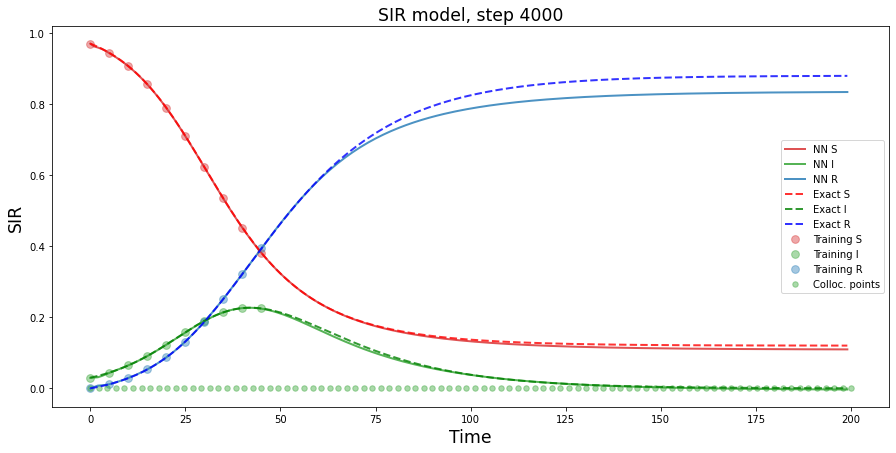

step = 4000 , loss1 = 3.3417535e-07 , loss2 = 2.2179209e-07 , loss = 5.5596746e-07 , mse = 0.00038757533 , beta = 0.15019307 , gamma = 0.06323273
step = 5000 , loss1 = 5.1910284e-08 , loss2 = 1.818852e-07 , loss = 2.3379548e-07 , mse = 0.00056432496 , beta = 0.15034488 , gamma = 0.06407177
step = 6000 , loss1 = 4.7532053e-06 , loss2 = 2.708654e-07 , loss = 5.0240706e-06 , mse = 0.001368832 , beta = 0.14879689 , gamma = 0.06428673


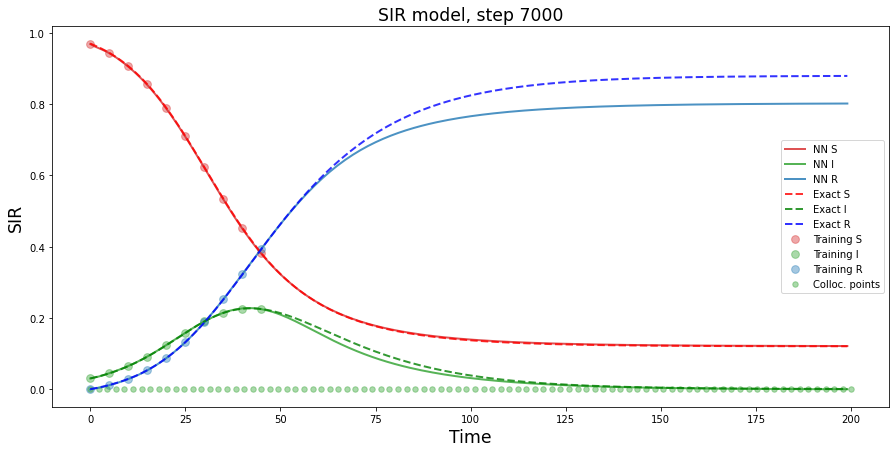

step = 7000 , loss1 = 1.1201147e-06 , loss2 = 2.4793e-07 , loss = 1.3680447e-06 , mse = 0.001019962 , beta = 0.1506606 , gamma = 0.064453304
step = 8000 , loss1 = 2.548465e-06 , loss2 = 1.5055147e-07 , loss = 2.6990165e-06 , mse = 0.0005128711 , beta = 0.1500716 , gamma = 0.06404595
step = 9000 , loss1 = 1.11447025e-05 , loss2 = 2.3078186e-07 , loss = 1.1375484e-05 , mse = 0.0005934548 , beta = 0.14960387 , gamma = 0.06307764
step = 10000 , loss1 = 8.0220275e-07 , loss2 = 1.3616673e-07 , loss = 9.3836945e-07 , mse = 0.0005338794 , beta = 0.15004766 , gamma = 0.06391704
step = 11000 , loss1 = 1.3595125e-05 , loss2 = 2.5210193e-07 , loss = 1.3847227e-05 , mse = 0.0009827137 , beta = 0.14922914 , gamma = 0.06311548
step = 12000 , loss1 = 6.581429e-07 , loss2 = 9.392899e-08 , loss = 7.5207186e-07 , mse = 0.00035987358 , beta = 0.15027796 , gamma = 0.06375934
step = 13000 , loss1 = 1.6522906e-08 , loss2 = 1.8930663e-07 , loss = 2.0582954e-07 , mse = 0.00078070676 , beta = 0.14975691 , gamma

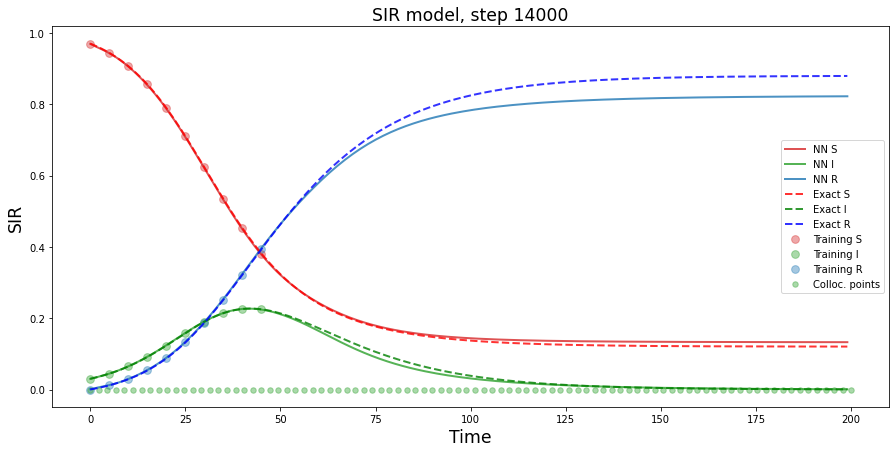

step = 14000 , loss1 = 9.255116e-07 , loss2 = 1.6889373e-07 , loss = 1.0944053e-06 , mse = 0.00057309365 , beta = 0.15074117 , gamma = 0.063787475
step = 15000 , loss1 = 7.305396e-06 , loss2 = 1.9279989e-07 , loss = 7.498196e-06 , mse = 0.00044884608 , beta = 0.14788868 , gamma = 0.06200957
step = 16000 , loss1 = 2.9217392e-07 , loss2 = 6.381621e-08 , loss = 3.5599012e-07 , mse = 0.0002163709 , beta = 0.14998876 , gamma = 0.063361086
step = 17000 , loss1 = 9.850711e-07 , loss2 = 8.634041e-08 , loss = 1.0714115e-06 , mse = 0.0003639149 , beta = 0.14993858 , gamma = 0.06335258
step = 18000 , loss1 = 8.787902e-06 , loss2 = 8.2976385e-08 , loss = 8.870878e-06 , mse = 0.00013524976 , beta = 0.14994003 , gamma = 0.06307867
step = 19000 , loss1 = 1.3918995e-07 , loss2 = 1.9644879e-06 , loss = 2.1036778e-06 , mse = 0.010710434 , beta = 0.14755094 , gamma = 0.06230042
step = 20000 , loss1 = 2.8430517e-08 , loss2 = 4.140115e-07 , loss = 4.4244203e-07 , mse = 0.0024870494 , beta = 0.14981604 , ga

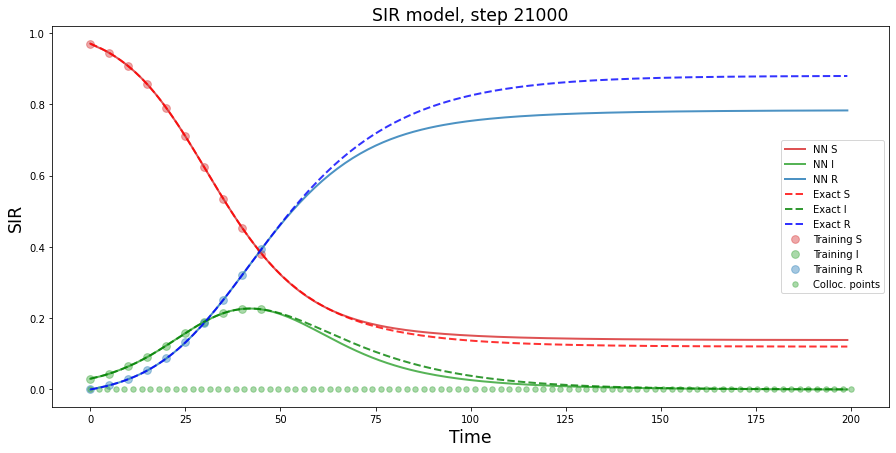

step = 21000 , loss1 = 1.7335697e-08 , loss2 = 2.6003482e-07 , loss = 2.7737053e-07 , mse = 0.0016175967 , beta = 0.14978352 , gamma = 0.063833505
step = 22000 , loss1 = 1.4239743e-06 , loss2 = 1.06352104e-07 , loss = 1.5303264e-06 , mse = 0.0005561525 , beta = 0.15041019 , gamma = 0.063654505
step = 23000 , loss1 = 2.0457849e-06 , loss2 = 1.04632846e-07 , loss = 2.1504177e-06 , mse = 0.00053999457 , beta = 0.15037453 , gamma = 0.0636726
step = 24000 , loss1 = 2.4754286e-08 , loss2 = 1.0054643e-07 , loss = 1.2530072e-07 , mse = 0.0005377266 , beta = 0.15022977 , gamma = 0.06379409
step = 25000 , loss1 = 3.400338e-07 , loss2 = 1.2391509e-07 , loss = 4.6394888e-07 , mse = 0.0006441889 , beta = 0.15051928 , gamma = 0.06354507
step = 26000 , loss1 = 5.138289e-07 , loss2 = 4.783304e-08 , loss = 5.61662e-07 , mse = 0.00020041702 , beta = 0.1505849 , gamma = 0.063755274
step = 27000 , loss1 = 9.963042e-06 , loss2 = 6.2989535e-08 , loss = 1.0026032e-05 , mse = 7.608526e-05 , beta = 0.1500679 ,

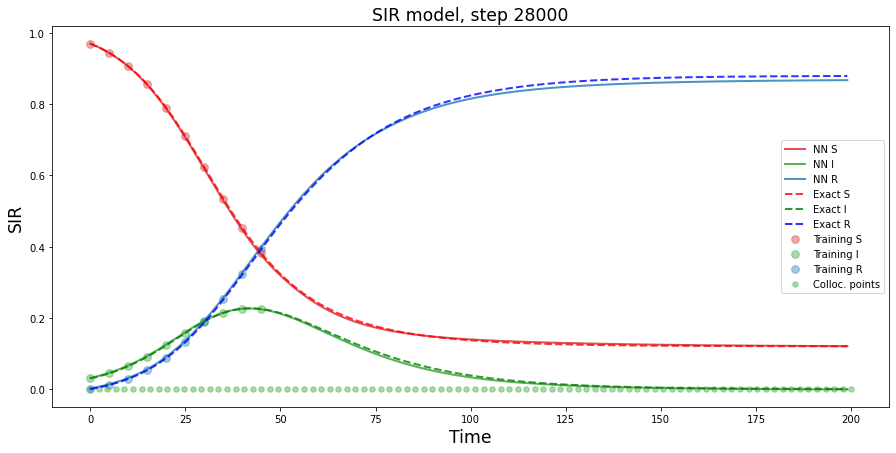

step = 28000 , loss1 = 9.174532e-06 , loss2 = 5.911902e-08 , loss = 9.233651e-06 , mse = 3.7372432e-05 , beta = 0.15009545 , gamma = 0.06318487
step = 29000 , loss1 = 5.914755e-07 , loss2 = 4.1033623e-08 , loss = 6.325091e-07 , mse = 7.6835204e-05 , beta = 0.1502276 , gamma = 0.06333037
step = 30000 , loss1 = 7.7541135e-06 , loss2 = 5.7674825e-08 , loss = 7.811788e-06 , mse = 4.7093174e-05 , beta = 0.14984812 , gamma = 0.0631616
step = 31000 , loss1 = 1.1870537e-08 , loss2 = 6.500873e-08 , loss = 7.687927e-08 , mse = 0.00015242952 , beta = 0.15038374 , gamma = 0.06338746
step = 32000 , loss1 = 1.1675847e-09 , loss2 = 2.437381e-08 , loss = 2.5541395e-08 , mse = 3.1878568e-05 , beta = 0.15043877 , gamma = 0.06336902
step = 33000 , loss1 = 1.8936059e-06 , loss2 = 3.61876e-08 , loss = 1.9297936e-06 , mse = 9.016827e-05 , beta = 0.1498073 , gamma = 0.062870815
step = 34000 , loss1 = 2.1801618e-06 , loss2 = 2.907247e-08 , loss = 2.2092343e-06 , mse = 5.656797e-05 , beta = 0.1503472 , gamma =

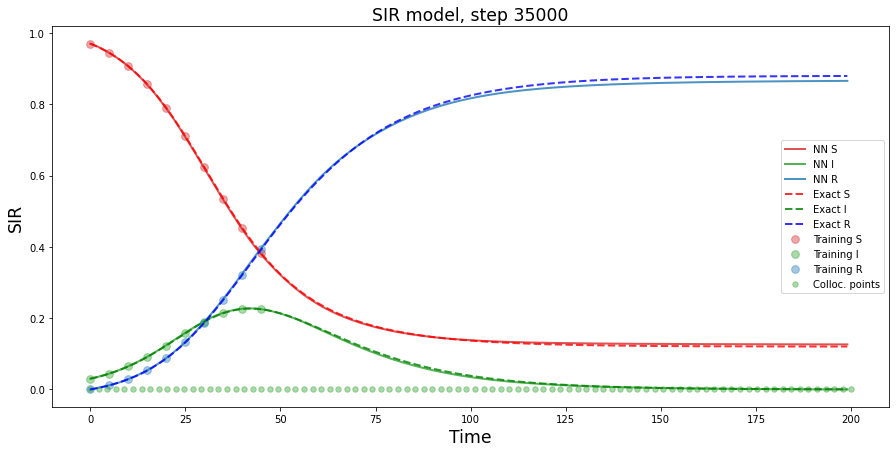

step = 35000 , loss1 = 3.4517836e-06 , loss2 = 3.3107966e-08 , loss = 3.4848915e-06 , mse = 3.8087728e-05 , beta = 0.15015972 , gamma = 0.06334274
step = 36000 , loss1 = 8.673488e-06 , loss2 = 7.532194e-08 , loss = 8.74881e-06 , mse = 0.000118179756 , beta = 0.14989401 , gamma = 0.06309687
step = 37000 , loss1 = 1.1901459e-08 , loss2 = 1.5698674e-07 , loss = 1.688882e-07 , mse = 0.0005395113 , beta = 0.15054993 , gamma = 0.063730255
step = 38000 , loss1 = 1.3198787e-09 , loss2 = 2.4079913e-08 , loss = 2.5399792e-08 , mse = 1.9060677e-05 , beta = 0.15061143 , gamma = 0.063463755
step = 39000 , loss1 = 5.108333e-10 , loss2 = 2.1979918e-08 , loss = 2.2490752e-08 , mse = 3.7133133e-05 , beta = 0.15055369 , gamma = 0.06350644
step = 40000 , loss1 = 2.017281e-06 , loss2 = 4.386269e-08 , loss = 2.0611437e-06 , mse = 4.765999e-05 , beta = 0.15125126 , gamma = 0.06405358
step = 41000 , loss1 = 1.3851854e-06 , loss2 = 2.396391e-08 , loss = 1.4091494e-06 , mse = 1.7839404e-05 , beta = 0.15042815 

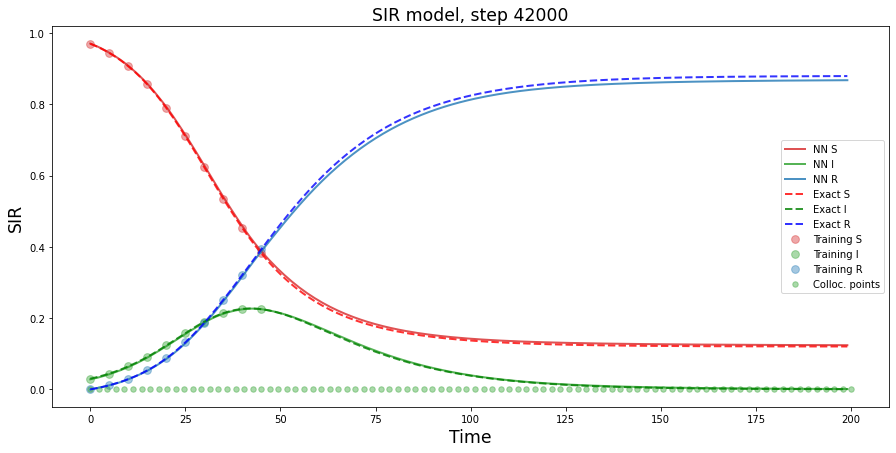

step = 42000 , loss1 = 8.799666e-06 , loss2 = 3.6150247e-08 , loss = 8.8358165e-06 , mse = 4.7737005e-05 , beta = 0.14989014 , gamma = 0.063283
step = 43000 , loss1 = 2.9882846e-10 , loss2 = 1.5932507e-08 , loss = 1.6231334e-08 , mse = 7.066766e-06 , beta = 0.15064755 , gamma = 0.06346523
step = 44000 , loss1 = 1.311217e-05 , loss2 = 3.8298907e-08 , loss = 1.31504685e-05 , mse = 4.0093648e-05 , beta = 0.14944817 , gamma = 0.062976584
step = 45000 , loss1 = 3.951818e-08 , loss2 = 1.29484565e-08 , loss = 5.246664e-08 , mse = 3.0018848e-06 , beta = 0.15041716 , gamma = 0.063414425
step = 46000 , loss1 = 6.3509596e-08 , loss2 = 4.0112644e-07 , loss = 4.6463603e-07 , mse = 0.001105816 , beta = 0.14967507 , gamma = 0.06395911
step = 47000 , loss1 = 5.2474486e-10 , loss2 = 2.891231e-08 , loss = 2.9437055e-08 , mse = 1.3070471e-05 , beta = 0.15067306 , gamma = 0.063548714
step = 48000 , loss1 = 1.809927e-08 , loss2 = 2.5012277e-08 , loss = 4.3111548e-08 , mse = 3.149444e-05 , beta = 0.15055284

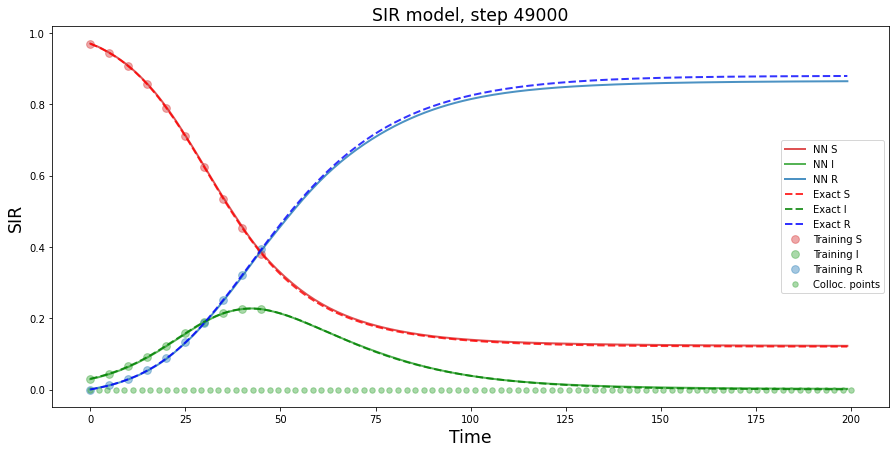

step = 49000 , loss1 = 3.1596142e-06 , loss2 = 4.2433925e-08 , loss = 3.202048e-06 , mse = 4.231078e-05 , beta = 0.15010922 , gamma = 0.06358195
step = 50000 , loss1 = 5.4183356e-06 , loss2 = 3.0275306e-08 , loss = 5.448611e-06 , mse = 2.8810957e-05 , beta = 0.15007126 , gamma = 0.06334067
step = 51000 , loss1 = 1.411878e-06 , loss2 = 7.9046146e-08 , loss = 1.4909241e-06 , mse = 3.844503e-05 , beta = 0.15035889 , gamma = 0.063660756
step = 52000 , loss1 = 1.5857826e-07 , loss2 = 1.2195365e-08 , loss = 1.7077363e-07 , mse = 1.7965416e-06 , beta = 0.15058248 , gamma = 0.06344731
step = 53000 , loss1 = 1.9489098e-10 , loss2 = 2.4209285e-08 , loss = 2.4404176e-08 , mse = 1.0646535e-05 , beta = 0.15051395 , gamma = 0.0634299
step = 54000 , loss1 = 5.8157094e-11 , loss2 = 7.145201e-09 , loss = 7.203358e-09 , mse = 6.4659326e-07 , beta = 0.15054385 , gamma = 0.063442975
step = 55000 , loss1 = 9.8133086e-08 , loss2 = 6.2532365e-08 , loss = 1.6066545e-07 , mse = 7.1837394e-06 , beta = 0.1486077

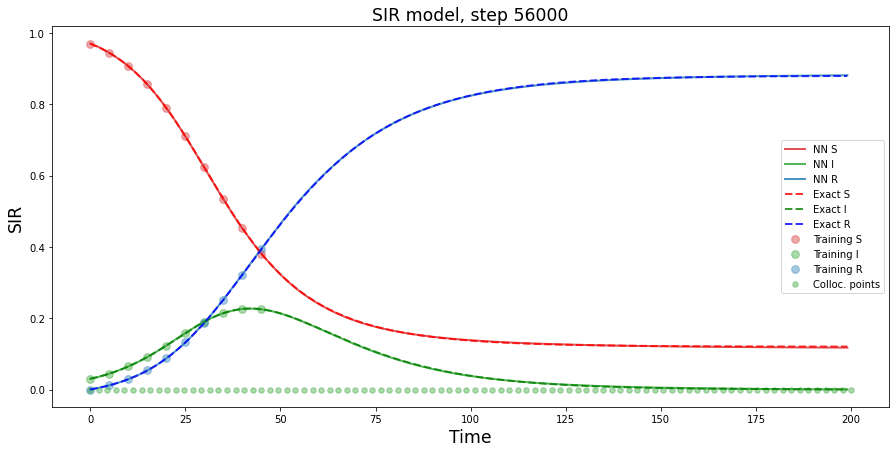

step = 56000 , loss1 = 2.0339134e-07 , loss2 = 1.8996383e-08 , loss = 2.2238773e-07 , mse = 9.602775e-07 , beta = 0.15031567 , gamma = 0.06331593
step = 57000 , loss1 = 7.4131736e-07 , loss2 = 2.6773378e-08 , loss = 7.6809073e-07 , mse = 3.550859e-06 , beta = 0.15035771 , gamma = 0.06333178
step = 58000 , loss1 = 2.7902834e-08 , loss2 = 4.4763755e-07 , loss = 4.755404e-07 , mse = 0.0011528138 , beta = 0.15018287 , gamma = 0.0644179
step = 59000 , loss1 = 2.6293117e-06 , loss2 = 1.1633119e-07 , loss = 2.7456429e-06 , mse = 0.00018894683 , beta = 0.15010673 , gamma = 0.06378728
step = 60000 , loss1 = 1.15349605e-08 , loss2 = 7.531718e-08 , loss = 8.685214e-08 , mse = 7.457279e-05 , beta = 0.150287 , gamma = 0.06341565
step = 61000 , loss1 = 4.1612278e-10 , loss2 = 5.0039162e-08 , loss = 5.0455284e-08 , mse = 3.7774855e-05 , beta = 0.15046473 , gamma = 0.063418455
step = 62000 , loss1 = 1.0511768e-06 , loss2 = 7.4000766e-08 , loss = 1.1251776e-06 , mse = 2.2416149e-05 , beta = 0.14926508 

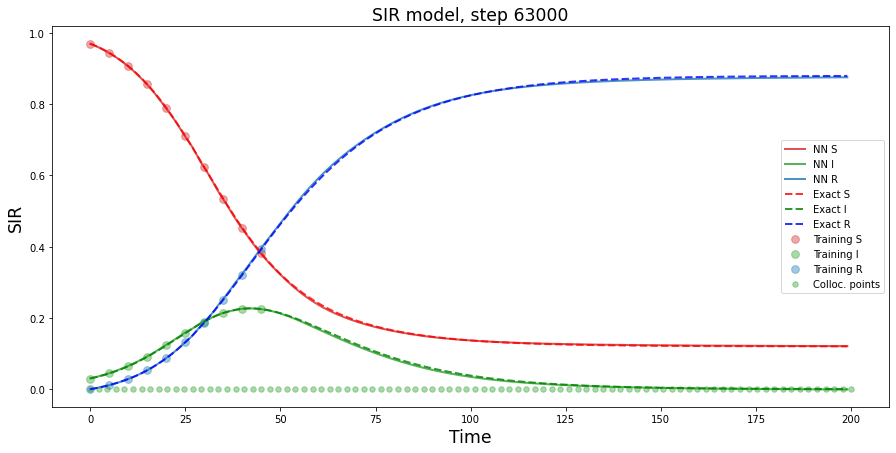

step = 63000 , loss1 = 1.7563398e-06 , loss2 = 8.254144e-08 , loss = 1.8388812e-06 , mse = 6.6910957e-06 , beta = 0.1504813 , gamma = 0.06331155
step = 64000 , loss1 = 1.5179398e-06 , loss2 = 1.10344224e-07 , loss = 1.628284e-06 , mse = 3.515007e-06 , beta = 0.15012304 , gamma = 0.06297014
step = 65000 , loss1 = 4.963804e-06 , loss2 = 9.4641564e-08 , loss = 5.0584454e-06 , mse = 2.4364885e-05 , beta = 0.14960499 , gamma = 0.06315422
step = 66000 , loss1 = 2.6554563e-08 , loss2 = 1.1684506e-06 , loss = 1.1950051e-06 , mse = 0.0064548817 , beta = 0.14942828 , gamma = 0.064714685
step = 67000 , loss1 = 3.8292303e-09 , loss2 = 4.5229143e-07 , loss = 4.5612066e-07 , mse = 0.002788873 , beta = 0.1500078 , gamma = 0.064542055
step = 68000 , loss1 = 2.527196e-10 , loss2 = 5.3730325e-08 , loss = 5.3983044e-08 , mse = 0.00018822617 , beta = 0.15052906 , gamma = 0.06368619
step = 69000 , loss1 = 3.8184113e-05 , loss2 = 9.635084e-08 , loss = 3.8280465e-05 , mse = 0.0001480576 , beta = 0.14954846 ,

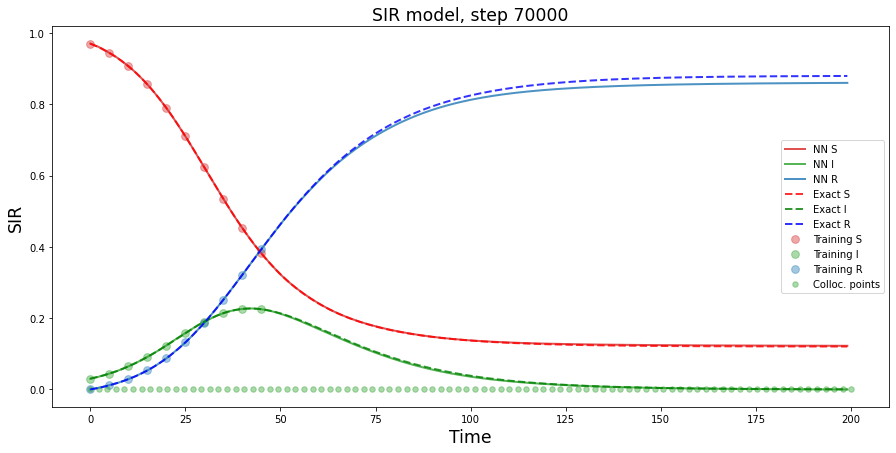

step = 70000 , loss1 = 3.7644396e-10 , loss2 = 3.0808625e-08 , loss = 3.118507e-08 , mse = 6.243172e-05 , beta = 0.15048423 , gamma = 0.0635721


In [19]:
x_data = sim_t_train
y_data = sim_data_train
x = sim_t
y = sim_data

# ......................
N = 1.0
torch.manual_seed(123)
modelD = FCND(1,3,42,4)

optimizer = torch.optim.Adam(modelD.parameters(),lr=3e-3)

steps = 70000
print_steps = 500
n_prints = steps // print_steps

sim_loss1_history = np.zeros(n_prints)
sim_loss2_history = np.zeros(n_prints)
sim_loss_history = np.zeros(n_prints)
sim_mse_history = np.zeros(n_prints)
sim_beta_history = np.zeros(n_prints)
sim_gamma_history = np.zeros(n_prints)

x_physics = torch.linspace(0.,200,90).view(-1,1).requires_grad_(True)

for i in range(steps):
    #lim= np.minimum(200*i/74000.,200)
    #x_physics = torch.linspace(0.,lim,90).view(-1,1).requires_grad_(True)#
    optimizer.zero_grad()
    
    # compute the "data loss" ..................................................
    yh = modelD(x_data)
    loss1 = 1*torch.mean((yh-y_data)**2)
    
    # compute the "physics loss" with enforcing the initial data ..............
    yhp = modelD(x_physics)
    yhp1= yhp[:,0].view(-1,1)
    yhp2= yhp[:,1].view(-1,1) 
    yhp3= yhp[:,2].view(-1,1)
    
    # compute first and second derivatives by automatic differentiation ....................
    dx1 = torch.autograd.grad(yhp1, x_physics, torch.ones_like(yhp1), create_graph=True)[0]
    dx2 = torch.autograd.grad(yhp2, x_physics, torch.ones_like(yhp2), create_graph=True)[0]
    dx3 = torch.autograd.grad(yhp3, x_physics, torch.ones_like(yhp3), create_graph=True)[0]
    #! aqui quede
    # computes the residual .............................................
    physics2 = (dx1 + (modelD.beta/N)*yhp1*yhp2)                
    physics1 = (dx2 - (modelD.beta/N)*yhp1*yhp2 + modelD.gamma*yhp2)
    physics3 = (dx3 - modelD.gamma*yhp2)
    loss2 = 1*torch.mean((physics1)**2) + 1*torch.mean((physics2)**2) + 1*torch.mean((physics3)**2)
    
    # backpropagate the total loss ...............................................
    loss = loss1 + loss2  # add two loss terms together .....................
    loss.backward()
    optimizer.step()    
        
    # plot the result as training progresses ...............................
    
    if (i+1) % print_steps == 0: 
        i_print = i // print_steps
        sim_loss1_history[i_print] = loss1.detach().numpy()
        sim_loss2_history[i_print] = loss2.detach().numpy()
        sim_loss_history[i_print] = loss.detach().numpy()
        
        yh = modelD(x).detach()
        xp = x_physics.detach()
        
        yhpp=modelD(x)

        mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution .....
        sim_mse_history[i_print] = mse.detach().numpy()

        sim_beta_history[i_print] = modelD.beta.detach().numpy()[0]
        sim_gamma_history[i_print] = modelD.gamma.detach().numpy()[0]

        if (i+1) == 500: plot_result(i,x,y,x_data,y_data,yh,xp)
        if (i+1) % 1000 == 0 and (i+1) < 5000: plot_result(i,x,y,x_data,y_data,yh,xp)
        if (i+1) % 7000 == 0: plot_result(i,x,y,x_data,y_data,yh,xp)
        else: plt.close("all")
    if (i+1) % 1000 == 0: print('step =', i+1, ', loss1 =', loss1.detach().numpy(), ', loss2 =', loss2.detach().numpy(), ', loss =', loss.detach().numpy(),
                                ', mse =', mse.detach().numpy(), ', beta =', modelD.beta.detach().numpy()[0], ', gamma =', modelD.gamma.detach().numpy()[0])


Los mejores valores de beta y gamma son, beta = 0.15053188800811768 , gamma = 0.06344953179359436


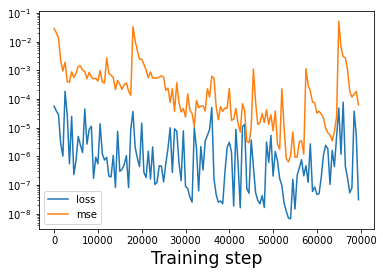

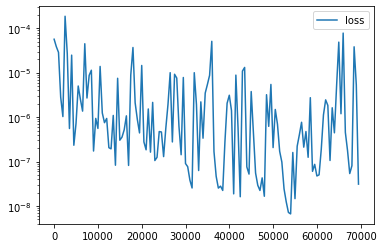

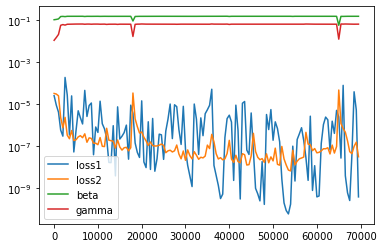

In [20]:
all_steps = np.arange(0, steps, print_steps)

fig33 = plt.figure(33)
plt.plot(all_steps,sim_loss_history, label="loss")
plt.plot(all_steps,sim_mse_history, label="mse")
plt.xlabel('Training step',fontsize="xx-large")
plt.yscale('log')
plt.legend()

fig50 = plt.figure(50)
plt.plot(all_steps,sim_loss1_history, label="loss1")
plt.plot(all_steps,sim_loss2_history, label="loss2")
plt.yscale('log')
plt.legend()

fig51 = plt.figure(51)
plt.plot(all_steps,sim_loss_history, label="loss")
plt.yscale('log')
plt.legend()

fig60 = plt.figure(60)
plt.plot(all_steps,sim_beta_history, label="beta")
plt.plot(all_steps,sim_gamma_history, label="gamma")
plt.legend()

#find the index of min loss
min_loss_index = np.argmin(sim_loss_history)
print('Los mejores valores de beta y gamma son, beta =', sim_beta_history[min_loss_index], ', gamma =', sim_gamma_history[min_loss_index])

### PINN sin busqueda de parametros

1000 tensor(2.6094e-06) tensor(4.4080e-06) tensor(7.0174e-06) tensor(0.0054, grad_fn=<MeanBackward0>)
2000 tensor(5.0077e-07) tensor(1.3291e-06) tensor(1.8299e-06) tensor(0.0021, grad_fn=<MeanBackward0>)
3000 tensor(7.6692e-07) tensor(7.6277e-07) tensor(1.5297e-06) tensor(0.0025, grad_fn=<MeanBackward0>)
4000 tensor(7.2960e-07) tensor(3.9311e-07) tensor(1.1227e-06) tensor(0.0013, grad_fn=<MeanBackward0>)


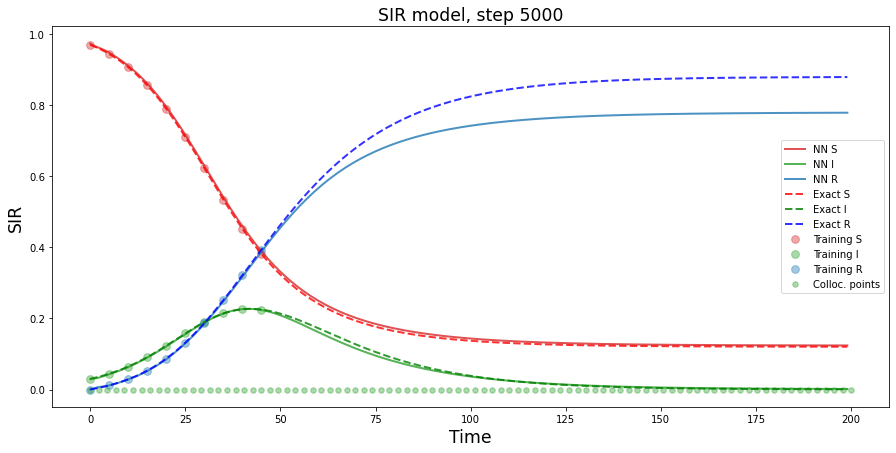

5000 tensor(6.5054e-06) tensor(3.6980e-07) tensor(6.8752e-06) tensor(0.0018, grad_fn=<MeanBackward0>)
6000 tensor(1.1417e-05) tensor(5.9660e-07) tensor(1.2014e-05) tensor(0.0026, grad_fn=<MeanBackward0>)
7000 tensor(6.9908e-06) tensor(5.1625e-07) tensor(7.5070e-06) tensor(0.0018, grad_fn=<MeanBackward0>)
8000 tensor(1.0788e-07) tensor(2.0910e-07) tensor(3.1698e-07) tensor(0.0011, grad_fn=<MeanBackward0>)
9000 tensor(5.8975e-08) tensor(1.4000e-07) tensor(1.9898e-07) tensor(0.0008, grad_fn=<MeanBackward0>)


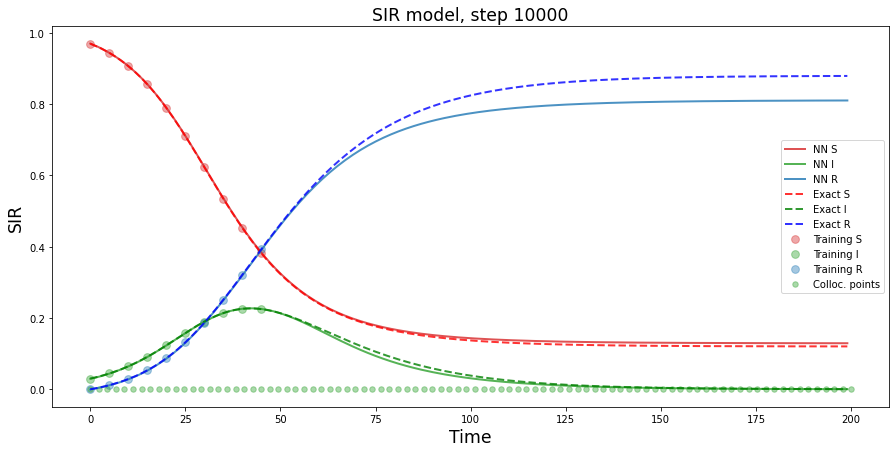

10000 tensor(9.6005e-07) tensor(1.3612e-07) tensor(1.0962e-06) tensor(0.0008, grad_fn=<MeanBackward0>)
11000 tensor(4.4581e-08) tensor(1.1265e-07) tensor(1.5723e-07) tensor(0.0006, grad_fn=<MeanBackward0>)
12000 tensor(2.4938e-05) tensor(1.4934e-07) tensor(2.5087e-05) tensor(0.0007, grad_fn=<MeanBackward0>)
13000 tensor(1.2122e-07) tensor(5.0899e-07) tensor(6.3021e-07) tensor(0.0019, grad_fn=<MeanBackward0>)
14000 tensor(2.7557e-07) tensor(3.8179e-07) tensor(6.5736e-07) tensor(0.0020, grad_fn=<MeanBackward0>)


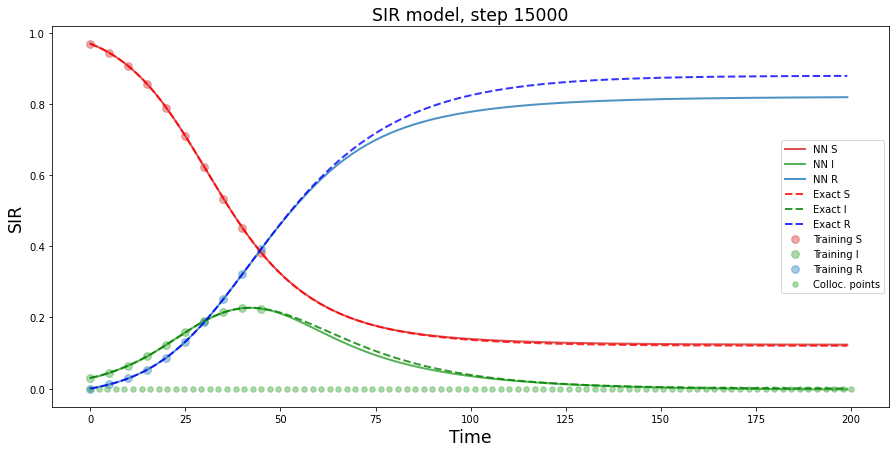

15000 tensor(1.6851e-08) tensor(1.6929e-07) tensor(1.8614e-07) tensor(0.0006, grad_fn=<MeanBackward0>)
16000 tensor(2.5665e-08) tensor(1.2570e-07) tensor(1.5136e-07) tensor(0.0005, grad_fn=<MeanBackward0>)
17000 tensor(2.5064e-08) tensor(8.7170e-08) tensor(1.1223e-07) tensor(0.0004, grad_fn=<MeanBackward0>)
18000 tensor(1.1698e-05) tensor(1.5129e-07) tensor(1.1850e-05) tensor(0.0001, grad_fn=<MeanBackward0>)
19000 tensor(1.9910e-06) tensor(1.2145e-07) tensor(2.1124e-06) tensor(0.0004, grad_fn=<MeanBackward0>)


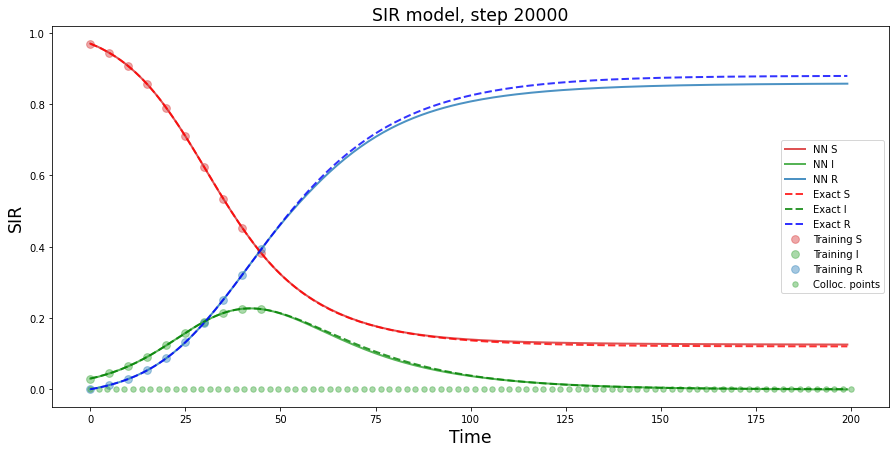

20000 tensor(1.0509e-08) tensor(3.8252e-08) tensor(4.8761e-08) tensor(9.1673e-05, grad_fn=<MeanBackward0>)
21000 tensor(7.6712e-07) tensor(6.4625e-08) tensor(8.3174e-07) tensor(0.0003, grad_fn=<MeanBackward0>)
22000 tensor(4.4141e-06) tensor(2.7707e-07) tensor(4.6912e-06) tensor(0.0007, grad_fn=<MeanBackward0>)
23000 tensor(1.4348e-08) tensor(2.4592e-08) tensor(3.8940e-08) tensor(1.7419e-05, grad_fn=<MeanBackward0>)
24000 tensor(1.4551e-07) tensor(2.1598e-08) tensor(1.6711e-07) tensor(1.5310e-05, grad_fn=<MeanBackward0>)


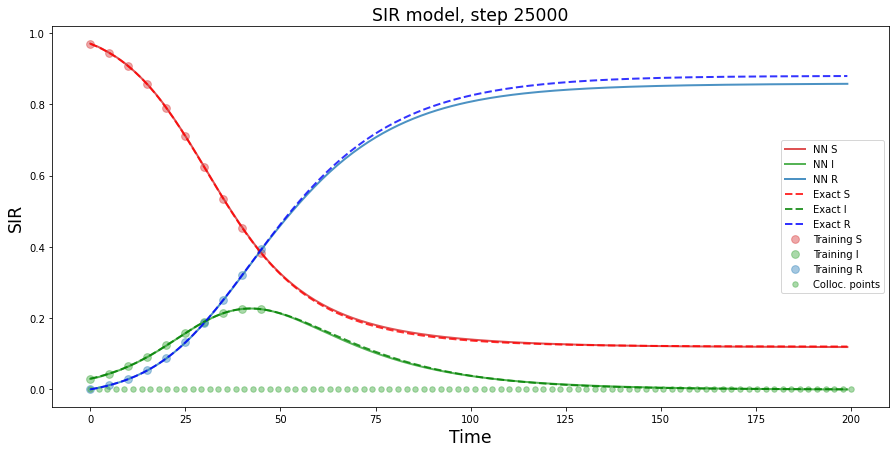

25000 tensor(3.9963e-07) tensor(3.0353e-08) tensor(4.2998e-07) tensor(9.0136e-05, grad_fn=<MeanBackward0>)
26000 tensor(1.2170e-07) tensor(5.9573e-07) tensor(7.1743e-07) tensor(0.0034, grad_fn=<MeanBackward0>)
27000 tensor(1.0765e-07) tensor(3.3294e-08) tensor(1.4094e-07) tensor(5.6514e-05, grad_fn=<MeanBackward0>)
28000 tensor(6.8223e-07) tensor(2.2374e-08) tensor(7.0461e-07) tensor(4.8424e-05, grad_fn=<MeanBackward0>)
29000 tensor(8.7879e-06) tensor(7.6895e-08) tensor(8.8648e-06) tensor(0.0002, grad_fn=<MeanBackward0>)


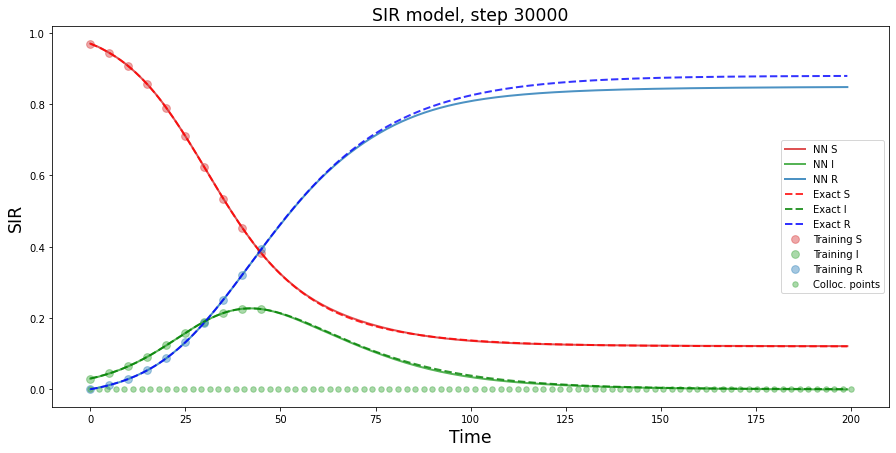

30000 tensor(1.8461e-08) tensor(4.0811e-08) tensor(5.9271e-08) tensor(0.0001, grad_fn=<MeanBackward0>)
31000 tensor(1.2223e-07) tensor(4.5039e-08) tensor(1.6727e-07) tensor(0.0002, grad_fn=<MeanBackward0>)
32000 tensor(2.0790e-07) tensor(3.3588e-08) tensor(2.4148e-07) tensor(7.8969e-05, grad_fn=<MeanBackward0>)
33000 tensor(1.7825e-06) tensor(1.0225e-06) tensor(2.8050e-06) tensor(0.0043, grad_fn=<MeanBackward0>)
34000 tensor(1.6946e-08) tensor(2.9274e-07) tensor(3.0969e-07) tensor(0.0012, grad_fn=<MeanBackward0>)


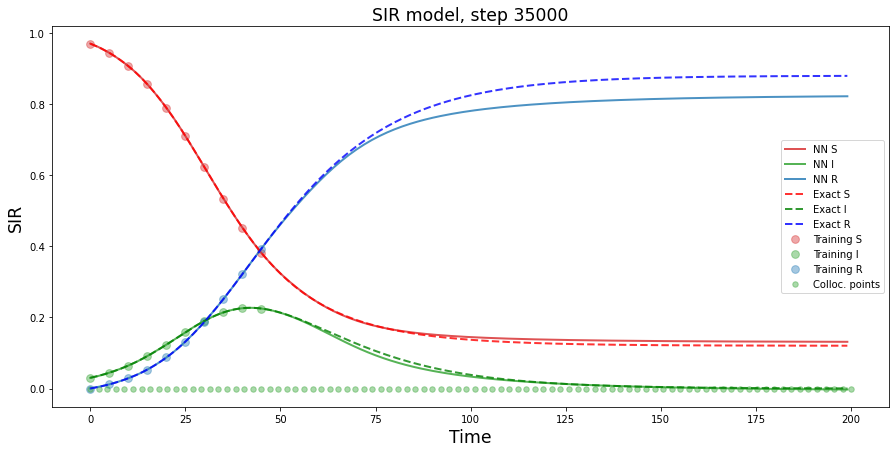

35000 tensor(7.5776e-09) tensor(1.8700e-07) tensor(1.9457e-07) tensor(0.0006, grad_fn=<MeanBackward0>)
36000 tensor(1.4801e-07) tensor(1.1911e-07) tensor(2.6712e-07) tensor(0.0003, grad_fn=<MeanBackward0>)
37000 tensor(3.8993e-09) tensor(4.8033e-08) tensor(5.1933e-08) tensor(9.4934e-05, grad_fn=<MeanBackward0>)
38000 tensor(2.6269e-07) tensor(2.1936e-08) tensor(2.8462e-07) tensor(2.4648e-05, grad_fn=<MeanBackward0>)
39000 tensor(6.9047e-07) tensor(2.5868e-08) tensor(7.1634e-07) tensor(5.3206e-05, grad_fn=<MeanBackward0>)


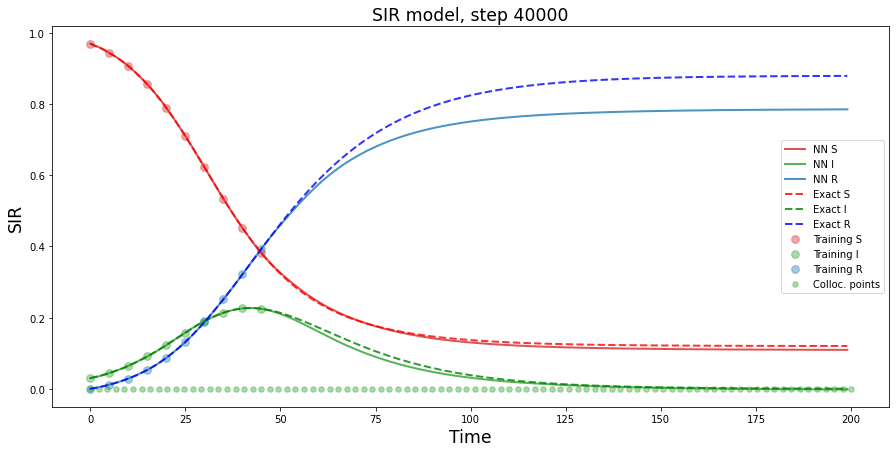

40000 tensor(4.4303e-08) tensor(4.0946e-07) tensor(4.5377e-07) tensor(0.0016, grad_fn=<MeanBackward0>)
41000 tensor(6.6728e-09) tensor(3.4876e-08) tensor(4.1549e-08) tensor(4.2860e-05, grad_fn=<MeanBackward0>)
42000 tensor(3.5515e-06) tensor(1.1881e-07) tensor(3.6703e-06) tensor(5.0894e-05, grad_fn=<MeanBackward0>)
43000 tensor(5.6495e-07) tensor(2.7279e-08) tensor(5.9223e-07) tensor(1.4752e-05, grad_fn=<MeanBackward0>)
44000 tensor(3.3467e-08) tensor(2.4330e-08) tensor(5.7797e-08) tensor(4.4793e-05, grad_fn=<MeanBackward0>)


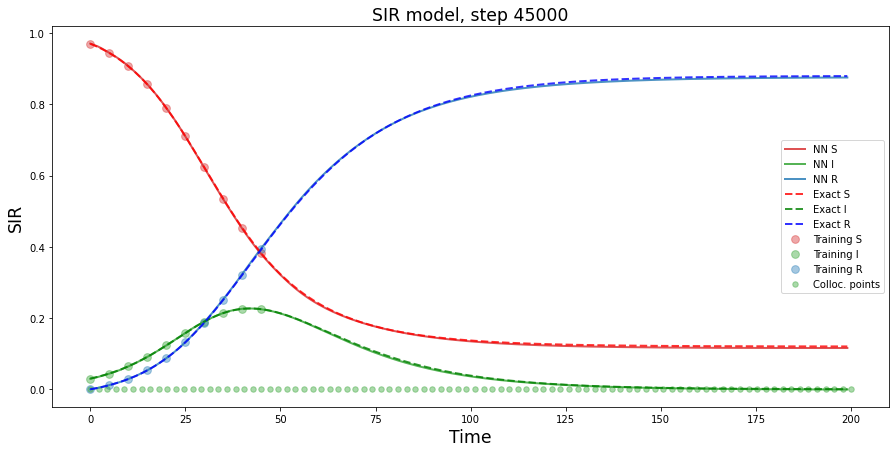

45000 tensor(8.8553e-07) tensor(2.9805e-08) tensor(9.1534e-07) tensor(8.1836e-06, grad_fn=<MeanBackward0>)
46000 tensor(7.6255e-07) tensor(1.8313e-08) tensor(7.8086e-07) tensor(3.5536e-06, grad_fn=<MeanBackward0>)
47000 tensor(1.3019e-06) tensor(1.8367e-08) tensor(1.3203e-06) tensor(1.4882e-06, grad_fn=<MeanBackward0>)
48000 tensor(6.3156e-09) tensor(3.8098e-07) tensor(3.8730e-07) tensor(0.0021, grad_fn=<MeanBackward0>)
49000 tensor(2.8953e-08) tensor(8.0107e-08) tensor(1.0906e-07) tensor(0.0003, grad_fn=<MeanBackward0>)


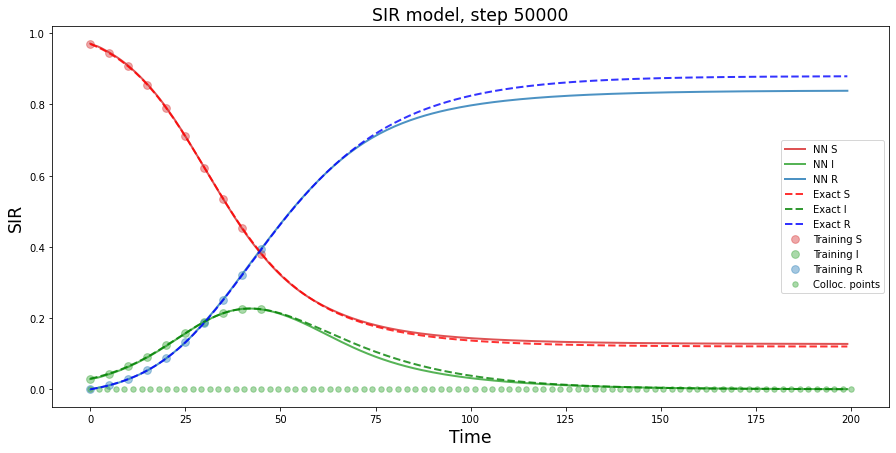

50000 tensor(3.8996e-06) tensor(1.5859e-07) tensor(4.0582e-06) tensor(0.0003, grad_fn=<MeanBackward0>)


In [21]:
# ......................
ww=1.0
N = 1.0
beta = sim_beta_history[min_loss_index]
gamma = sim_gamma_history[min_loss_index]
torch.manual_seed(123)
model = FCN(1,3,42,4)

optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
files = []
loss1_history = []
loss2_history = []
loss_history = []
mse_history = []

x_physics = torch.linspace(0.,200,90).view(-1,1).requires_grad_(True)

for i in range(50000):
    #lim= np.minimum(200*i/74000.,200)
    #x_physics = torch.linspace(0.,lim,90).view(-1,1).requires_grad_(True)#
    optimizer.zero_grad()
    
    # compute the "data loss" ..................................................
    yh = model(x_data)
    loss1 = 1*torch.mean((yh-y_data)**2)
    
    # compute the "physics loss" with enforcing the initial data ..............
    yhp = model(x_physics)
    yhp1= yhp[:,0].view(-1,1)
    yhp2= yhp[:,1].view(-1,1) 
    yhp3= yhp[:,2].view(-1,1)
    
    # compute first and second derivatives by automatic differentiation ....................
    dx1 = torch.autograd.grad(yhp1, x_physics, torch.ones_like(yhp1), create_graph=True)[0]
    dx2 = torch.autograd.grad(yhp2, x_physics, torch.ones_like(yhp2), create_graph=True)[0]
    dx3 = torch.autograd.grad(yhp3, x_physics, torch.ones_like(yhp3), create_graph=True)[0]
    #! aqui quede
    # computes the residual .............................................
    physics2 = (dx1 + beta/N*yhp1*yhp2)                
    physics1 = (dx2 - beta/N*yhp1*yhp2 + gamma*yhp2)
    physics3 = (dx3 - gamma*yhp2)
    loss2 = 1*torch.mean((physics1)**2) + 1*torch.mean((physics2)**2) + 1*torch.mean((physics3)**2)
    
    # backpropagate the total loss ...............................................
    loss = loss1 + loss2  # add two loss terms together .....................
    loss.backward()
    optimizer.step()    
        
    # plot the result as training progresses ...............................
    
    if (i+1) % 500 == 0: 
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss_history.append(loss.detach())
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        yhpp=model(x)
        mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution .....
        mse_history.append(mse.detach())

        #if (i+1) == 500: plot_result(i,x,y,x_data,y_data,yh,xp)
        #if (i+1) % 1000 == 0 and (i+1) < 5000: plot_result(i,x,y,x_data,y_data,yh,xp)
        if (i+1) % 5000 == 0: plot_result(i,x,y,x_data,y_data,yh,xp)
        else: plt.close("all")
    if (i+1) % 1000 == 0: print(i+1, loss1.detach(), loss2.detach(), loss.detach(), mse)
    

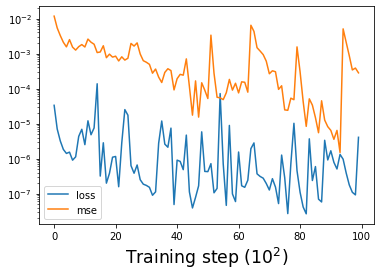

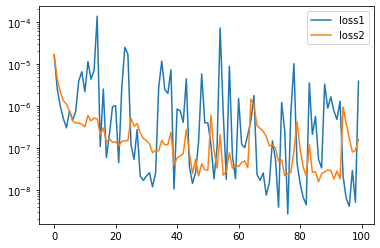

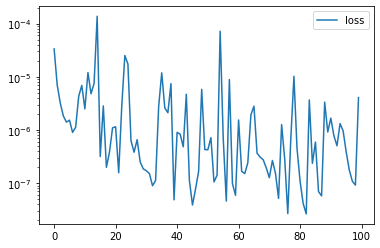

In [22]:
fig33 = plt.figure(33)
plt.plot(loss_history, label="loss")
plt.plot(mse_history, label="mse")
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.yscale('log')
plt.legend()

fig50 = plt.figure(50)
plt.plot(loss1_history, label="loss1")
plt.plot(loss2_history, label="loss2")
plt.yscale('log')
plt.legend()

fig51 = plt.figure(51)
plt.plot(loss_history, label="loss")
plt.yscale('log')
plt.legend()

# Alemania 

torch.Size([122, 1]) torch.Size([122, 3])
torch.Size([25, 1]) torch.Size([25, 3])


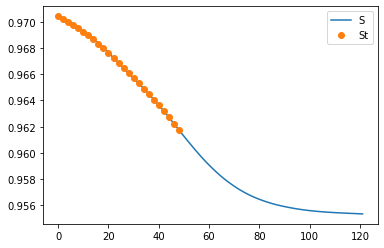

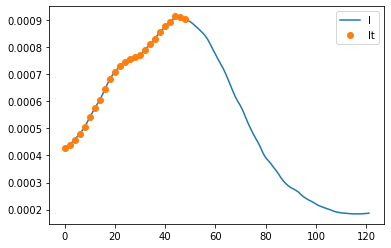

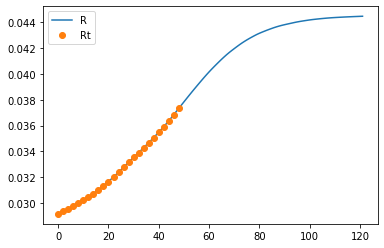

In [7]:
Alem = pd.read_csv('./Al_SIR.csv')
N_old = Alem['S'][0] + Alem['I'][0] + Alem['R'][0]
Alem['S'] = Alem['S'] / N_old
Alem['I'] = Alem['I'] / N_old
Alem['R'] = Alem['R'] / N_old

Alem_t = torch.tensor(Alem[['t']].values, dtype=torch.float32)
Alem_data = torch.tensor(Alem[['S', 'I', 'R']].values, dtype=torch.float32)

print(Alem_t.shape, Alem_data.shape)

Alem_t_train = Alem_t[:50:2]
Alem_data_train = Alem_data[:50:2]

print(Alem_t_train.shape, Alem_data_train.shape)

fig = plt.figure()
plt.plot(Alem_t, Alem_data[:,0], label='S' )
plt.plot(Alem_t_train, Alem_data_train[:,0], 'o', label='St')
plt.legend();

fig = plt.figure()
plt.plot(Alem_t, Alem_data[:,1], label='I' )
plt.plot(Alem_t_train, Alem_data_train[:,1], 'o', label='It')
plt.legend();

fig = plt.figure()
plt.plot(Alem_t, Alem_data[:,2], label='R' )
plt.plot(Alem_t_train, Alem_data_train[:,2], 'o', label='Rt')
plt.legend();

### PINN con busqueda de parametros

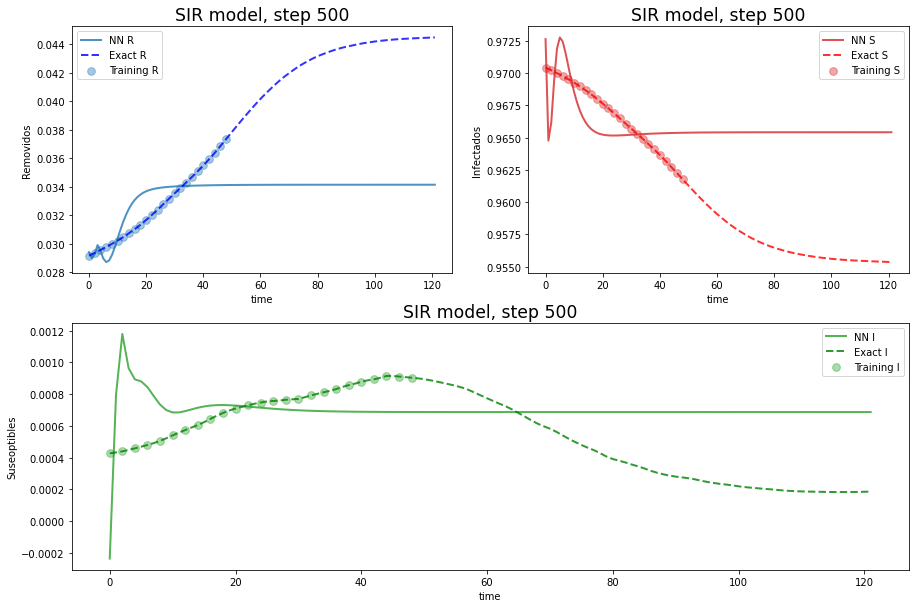

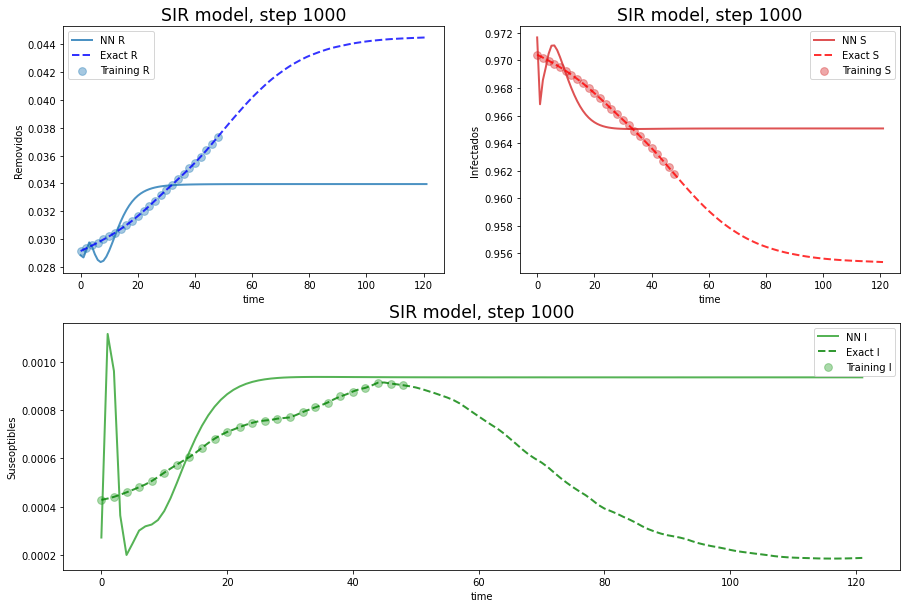

step = 1000 , loss1 = 1.8133462e-06 , loss2 = 1.2824124e-07 , loss = 1.9415875e-06 , mse = 3.0298239e-05 , beta = 0.018555148 , gamma = -0.0035161767


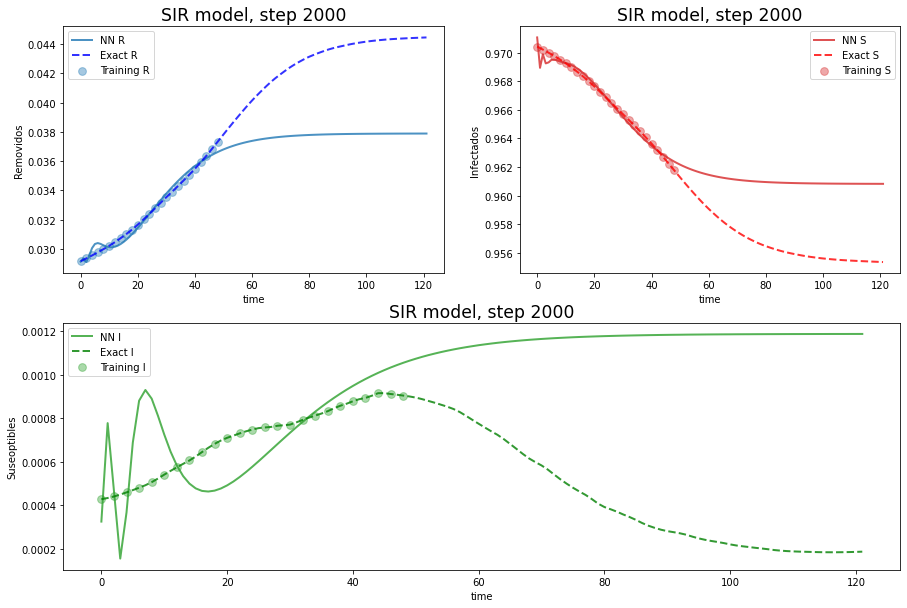

step = 2000 , loss1 = 7.302379e-08 , loss2 = 6.3307176e-08 , loss = 1.3633097e-07 , mse = 9.465824e-06 , beta = 0.015738523 , gamma = 0.013200611


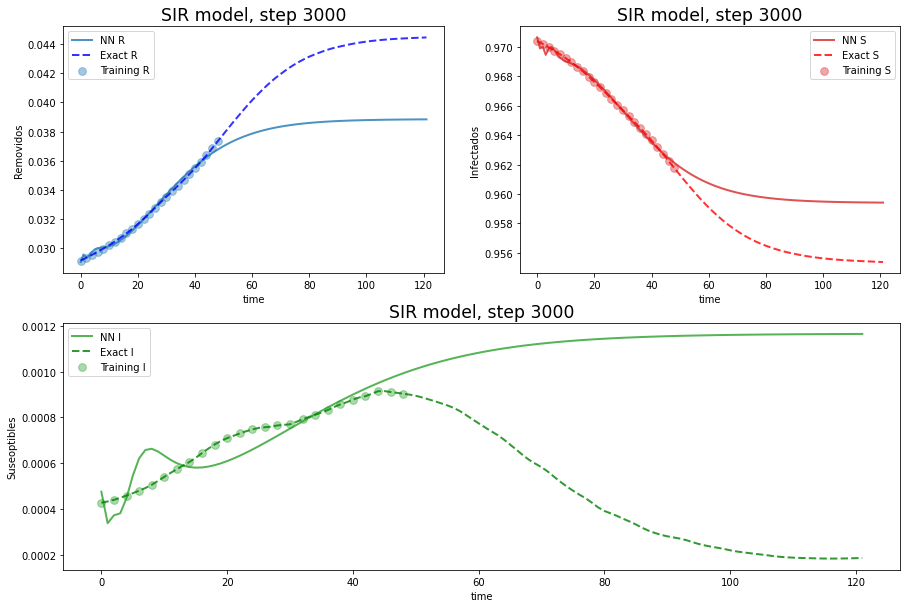

step = 3000 , loss1 = 2.1043377e-08 , loss2 = 3.184734e-08 , loss = 5.2890716e-08 , mse = 6.1520263e-06 , beta = 0.0036351832 , gamma = 0.0075405855


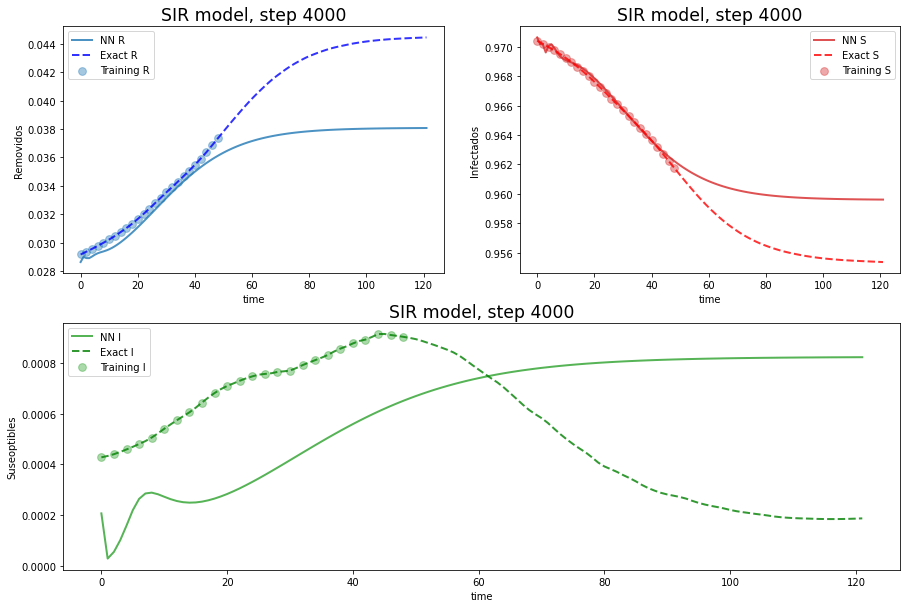

step = 4000 , loss1 = 1.1985334e-07 , loss2 = 2.7484422e-08 , loss = 1.4733776e-07 , mse = 7.744372e-06 , beta = 0.002836995 , gamma = 0.0060719512
step = 5000 , loss1 = 3.0494906e-08 , loss2 = 2.377966e-08 , loss = 5.4274565e-08 , mse = 7.84804e-06 , beta = 0.013523543 , gamma = 0.018995015
step = 6000 , loss1 = 1.3137084e-06 , loss2 = 2.3366017e-08 , loss = 1.3370744e-06 , mse = 1.4085051e-05 , beta = 0.004984288 , gamma = 0.011106565


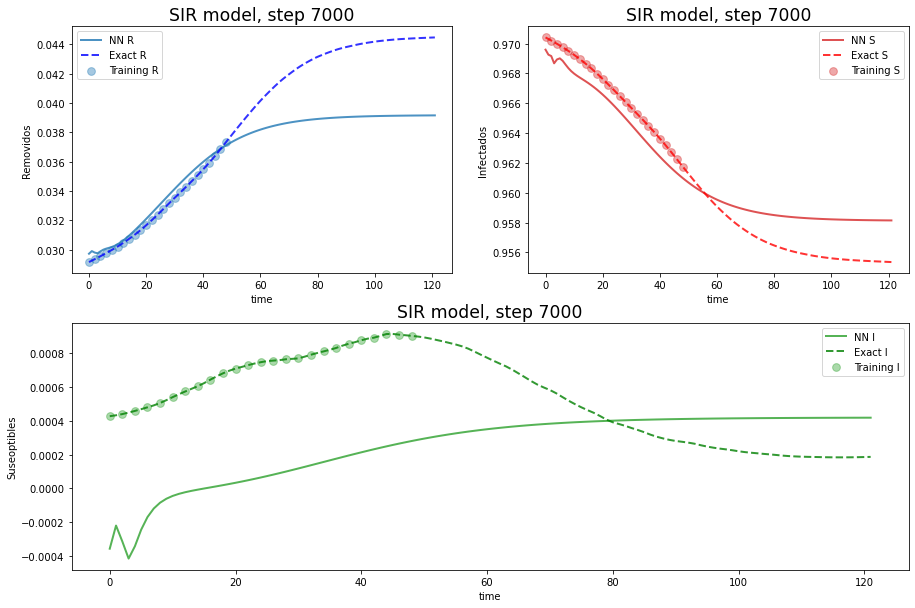

step = 7000 , loss1 = 9.845452e-07 , loss2 = 3.107484e-08 , loss = 1.01562e-06 , mse = 4.599149e-06 , beta = -0.008666697 , gamma = 0.0023243958
step = 8000 , loss1 = 3.030434e-05 , loss2 = 1.965781e-07 , loss = 3.0500918e-05 , mse = 2.7402162e-05 , beta = 0.026341321 , gamma = 0.014508404
step = 9000 , loss1 = 1.6744918e-08 , loss2 = 2.1212635e-08 , loss = 3.7957555e-08 , mse = 5.4704296e-06 , beta = 0.028005023 , gamma = 0.030648919
step = 10000 , loss1 = 8.9230575e-08 , loss2 = 2.5045093e-08 , loss = 1.14275664e-07 , mse = 5.464648e-06 , beta = 0.018307745 , gamma = 0.015410717
step = 11000 , loss1 = 5.0046623e-07 , loss2 = 3.1414856e-08 , loss = 5.318811e-07 , mse = 1.7639732e-05 , beta = -0.00017169082 , gamma = 0.0008753858
step = 12000 , loss1 = 3.2372675e-08 , loss2 = 2.0475795e-08 , loss = 5.284847e-08 , mse = 3.6585136e-06 , beta = 0.035398323 , gamma = 0.027805544
step = 13000 , loss1 = 1.1668524e-08 , loss2 = 1.6200257e-08 , loss = 2.7868781e-08 , mse = 2.8244556e-06 , beta

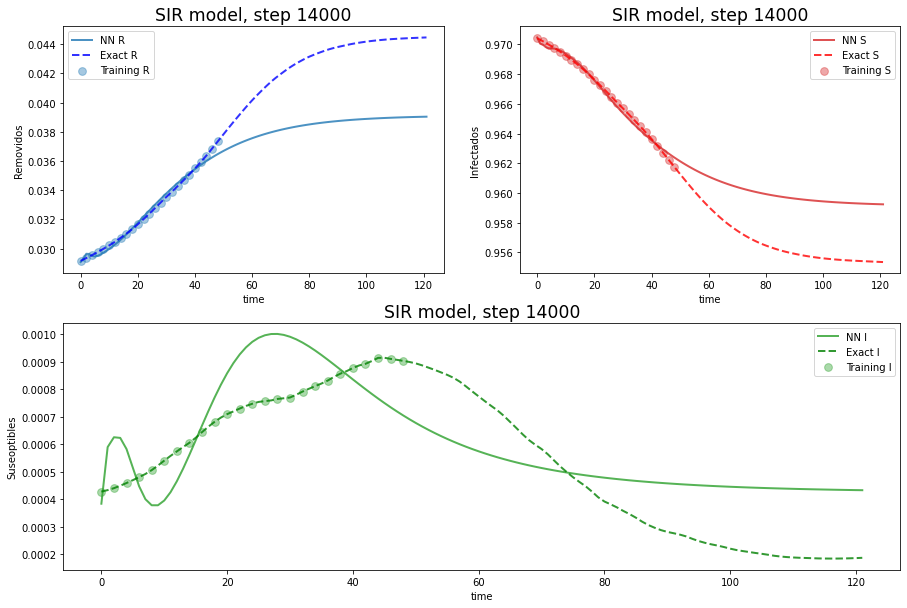

step = 14000 , loss1 = 5.7106785e-08 , loss2 = 1.5755425e-08 , loss = 7.286221e-08 , mse = 6.157792e-06 , beta = 0.06053749 , gamma = 0.056492124
step = 15000 , loss1 = 6.527252e-07 , loss2 = 1.15548e-08 , loss = 6.6428e-07 , mse = 3.55253e-06 , beta = 0.053814676 , gamma = 0.049361944
step = 16000 , loss1 = 1.0471219e-08 , loss2 = 1.6536838e-08 , loss = 2.7008056e-08 , mse = 2.71042e-06 , beta = 0.05906767 , gamma = 0.051342644
step = 17000 , loss1 = 2.117485e-06 , loss2 = 2.9320729e-08 , loss = 2.1468059e-06 , mse = 4.953961e-06 , beta = 0.047944263 , gamma = 0.040683195
step = 18000 , loss1 = 1.472939e-07 , loss2 = 2.1018602e-08 , loss = 1.6831251e-07 , mse = 2.6043572e-06 , beta = 0.06067137 , gamma = 0.052174572
step = 19000 , loss1 = 4.7273385e-08 , loss2 = 2.442793e-08 , loss = 7.1701315e-08 , mse = 7.4882687e-06 , beta = 0.00807533 , gamma = 0.0054013045
step = 20000 , loss1 = 8.588976e-09 , loss2 = 2.3636002e-08 , loss = 3.222498e-08 , mse = 3.468501e-06 , beta = 0.023331655 ,

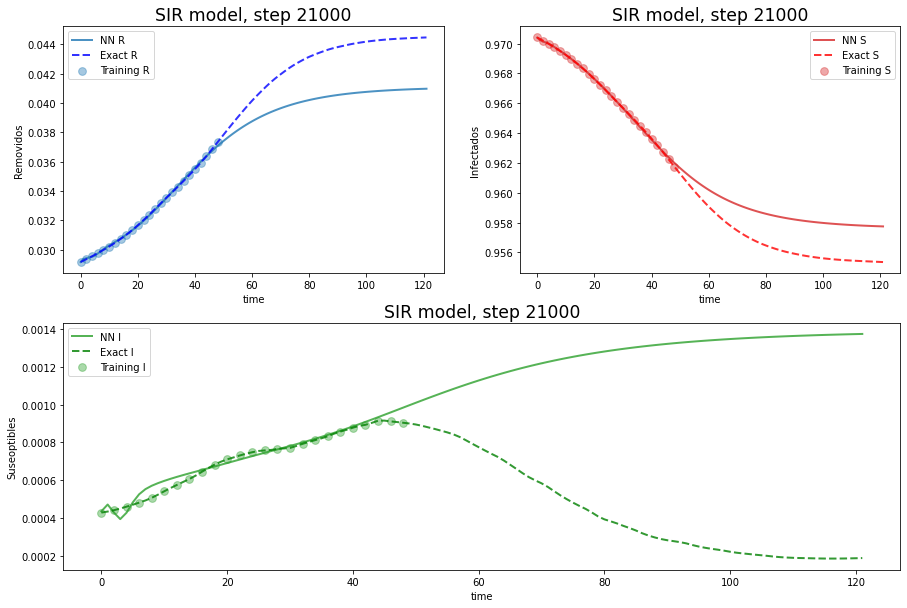

step = 21000 , loss1 = 4.009546e-09 , loss2 = 2.0682327e-08 , loss = 2.4691873e-08 , mse = 2.5657937e-06 , beta = 0.04207275 , gamma = 0.030376112
step = 22000 , loss1 = 5.618655e-09 , loss2 = 1.8006329e-08 , loss = 2.3624985e-08 , mse = 3.7400025e-06 , beta = 0.04578591 , gamma = 0.040575445
step = 23000 , loss1 = 5.3219114e-09 , loss2 = 1.9738199e-08 , loss = 2.506011e-08 , mse = 3.2539383e-06 , beta = 0.03826481 , gamma = 0.04008159
step = 24000 , loss1 = 8.955709e-09 , loss2 = 1.9788587e-08 , loss = 2.8744296e-08 , mse = 3.3151903e-06 , beta = 0.032718983 , gamma = 0.033165794
step = 25000 , loss1 = 2.1347313e-08 , loss2 = 1.6994605e-08 , loss = 3.8341916e-08 , mse = 4.194186e-06 , beta = 0.04502952 , gamma = 0.041394845
step = 26000 , loss1 = 8.563184e-08 , loss2 = 1.9371093e-08 , loss = 1.0500293e-07 , mse = 5.401006e-06 , beta = 0.047158774 , gamma = 0.04439078
step = 27000 , loss1 = 5.5575316e-07 , loss2 = 1.2492779e-08 , loss = 5.682459e-07 , mse = 5.9142876e-06 , beta = 0.056

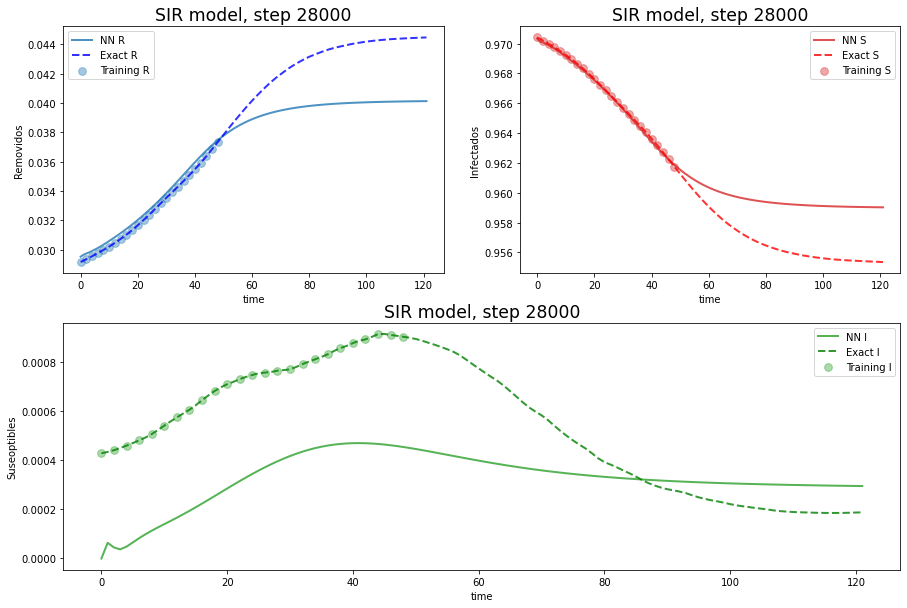

step = 28000 , loss1 = 9.407352e-08 , loss2 = 1.2061507e-08 , loss = 1.06135026e-07 , mse = 3.9158117e-06 , beta = 0.06565374 , gamma = 0.060634226
step = 29000 , loss1 = 1.8479693e-07 , loss2 = 3.14957e-08 , loss = 2.1629263e-07 , mse = 1.3245294e-05 , beta = -0.004168087 , gamma = -0.0032115192
step = 30000 , loss1 = 3.5980676e-08 , loss2 = 2.3603805e-08 , loss = 5.958448e-08 , mse = 5.7865004e-06 , beta = 0.020540202 , gamma = 0.016266448
step = 31000 , loss1 = 1.9408402e-08 , loss2 = 1.8885629e-08 , loss = 3.8294033e-08 , mse = 4.876909e-06 , beta = 0.04649546 , gamma = 0.040059738
step = 32000 , loss1 = 6.8906987e-09 , loss2 = 1.4771549e-08 , loss = 2.1662249e-08 , mse = 2.4173776e-06 , beta = 0.0767298 , gamma = 0.06813056
step = 33000 , loss1 = 3.765868e-09 , loss2 = 1.8774731e-08 , loss = 2.2540599e-08 , mse = 1.9171034e-06 , beta = 0.051762287 , gamma = 0.046701793
step = 34000 , loss1 = 1.4876463e-05 , loss2 = 1.1813137e-07 , loss = 1.49945945e-05 , mse = 1.7848812e-05 , beta

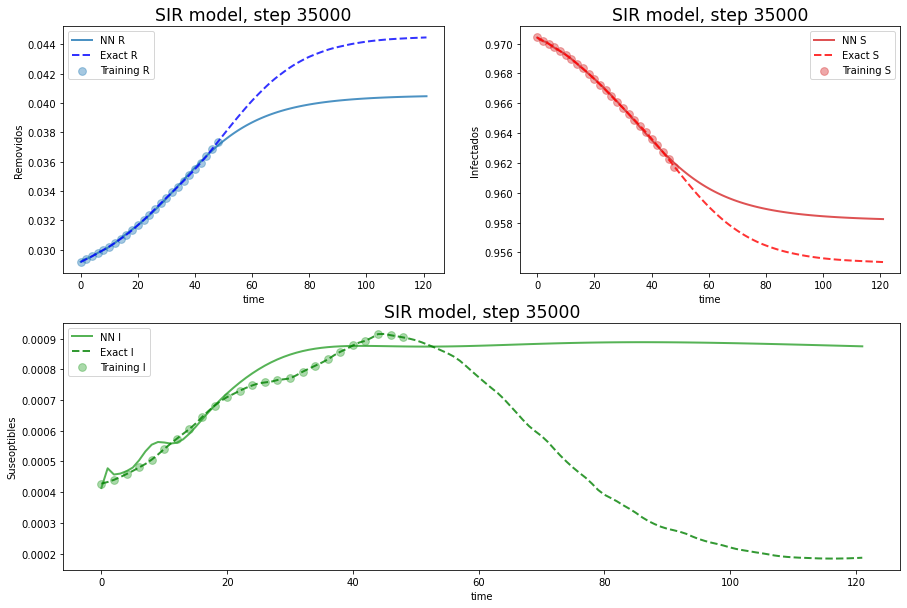

step = 35000 , loss1 = 3.8183154e-09 , loss2 = 1.5636894e-08 , loss = 1.945521e-08 , mse = 3.1678385e-06 , beta = 0.066101946 , gamma = 0.061282586
step = 36000 , loss1 = 8.2380026e-08 , loss2 = 1.9029496e-08 , loss = 1.01409526e-07 , mse = 5.853957e-06 , beta = 0.053625256 , gamma = 0.050546702
step = 37000 , loss1 = 1.3053312e-06 , loss2 = 3.0467895e-08 , loss = 1.3357991e-06 , mse = 8.4081985e-06 , beta = 0.0641479 , gamma = 0.058870643
step = 38000 , loss1 = 3.7178568e-06 , loss2 = 1.2817268e-08 , loss = 3.730674e-06 , mse = 1.2420526e-05 , beta = 0.09460106 , gamma = 0.08710662
step = 39000 , loss1 = 3.7106123e-08 , loss2 = 1.5536008e-08 , loss = 5.264213e-08 , mse = 5.913e-06 , beta = 0.066494815 , gamma = 0.060693912
step = 40000 , loss1 = 7.4087096e-09 , loss2 = 2.7173392e-08 , loss = 3.45821e-08 , mse = 4.157414e-06 , beta = 0.014676314 , gamma = 0.010300659
step = 41000 , loss1 = 2.9650238e-09 , loss2 = 1.951986e-08 , loss = 2.2484883e-08 , mse = 3.778417e-06 , beta = 0.04731

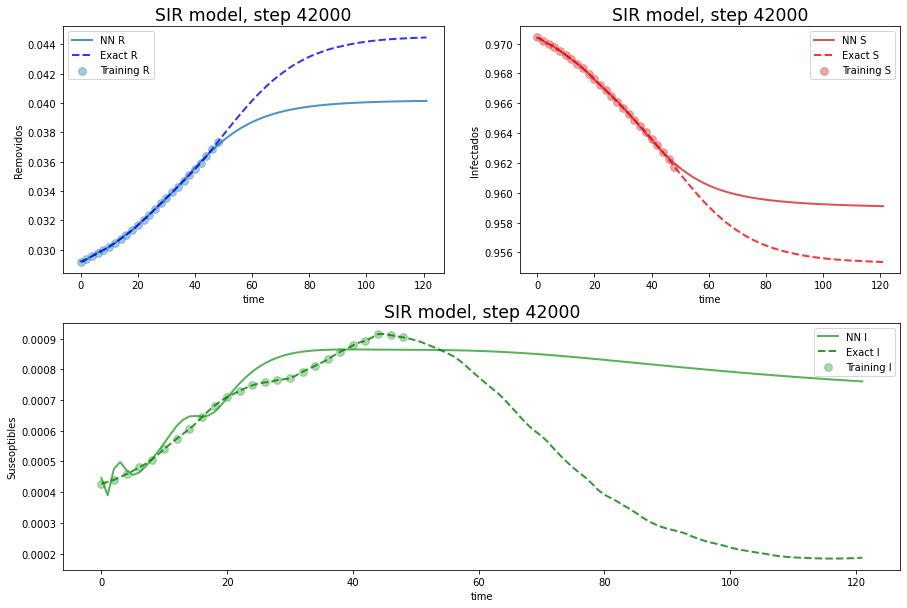

step = 42000 , loss1 = 3.3091363e-09 , loss2 = 1.4865968e-08 , loss = 1.8175104e-08 , mse = 4.080205e-06 , beta = 0.0765837 , gamma = 0.06749554
step = 43000 , loss1 = 2.2056823e-09 , loss2 = 9.011686e-09 , loss = 1.1217368e-08 , mse = 3.050785e-06 , beta = 0.11173127 , gamma = 0.10394296
step = 44000 , loss1 = 7.8117836e-08 , loss2 = 1.6237628e-08 , loss = 9.4355464e-08 , mse = 7.393079e-06 , beta = 0.046003167 , gamma = 0.042584017
step = 45000 , loss1 = 3.4193344e-09 , loss2 = 1.5791905e-08 , loss = 1.9211239e-08 , mse = 5.5799096e-06 , beta = 0.06463148 , gamma = 0.05769851
step = 46000 , loss1 = 1.59445e-08 , loss2 = 1.3216444e-08 , loss = 2.9160944e-08 , mse = 4.8385473e-06 , beta = 0.07993085 , gamma = 0.0723955
step = 47000 , loss1 = 3.795326e-08 , loss2 = 1.4818596e-08 , loss = 5.2771856e-08 , mse = 7.491138e-06 , beta = 0.06925534 , gamma = 0.063383296
step = 48000 , loss1 = 1.901932e-06 , loss2 = 1.8427443e-08 , loss = 1.9203594e-06 , mse = 1.4373902e-05 , beta = 0.062093202

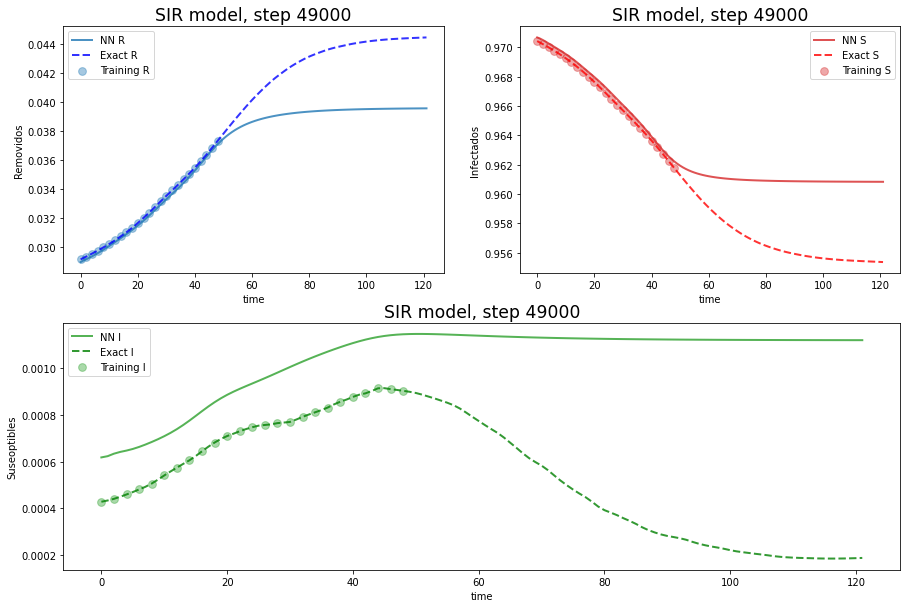

step = 49000 , loss1 = 3.5426694e-08 , loss2 = 2.1647388e-08 , loss = 5.7074082e-08 , mse = 6.724198e-06 , beta = 0.029984111 , gamma = 0.028846694
step = 50000 , loss1 = 1.3507724e-07 , loss2 = 4.0333664e-08 , loss = 1.754109e-07 , mse = 1.0841048e-05 , beta = -0.003214619 , gamma = -0.0024050544
step = 51000 , loss1 = 8.637895e-09 , loss2 = 2.3059924e-08 , loss = 3.169782e-08 , mse = 2.5205143e-06 , beta = 0.041786045 , gamma = 0.03418806
step = 52000 , loss1 = 7.4691755e-09 , loss2 = 1.8369109e-08 , loss = 2.5838284e-08 , mse = 2.9344899e-06 , beta = 0.049012538 , gamma = 0.04482137
step = 53000 , loss1 = 9.1716413e-07 , loss2 = 2.5098458e-08 , loss = 9.422626e-07 , mse = 4.3292907e-06 , beta = 0.038220283 , gamma = 0.033835392
step = 54000 , loss1 = 9.108831e-08 , loss2 = 1.8305434e-08 , loss = 1.09393746e-07 , mse = 5.403993e-06 , beta = 0.05550985 , gamma = 0.051314086
step = 55000 , loss1 = 1.3878271e-07 , loss2 = 1.5855342e-08 , loss = 1.5463806e-07 , mse = 6.853216e-06 , beta 

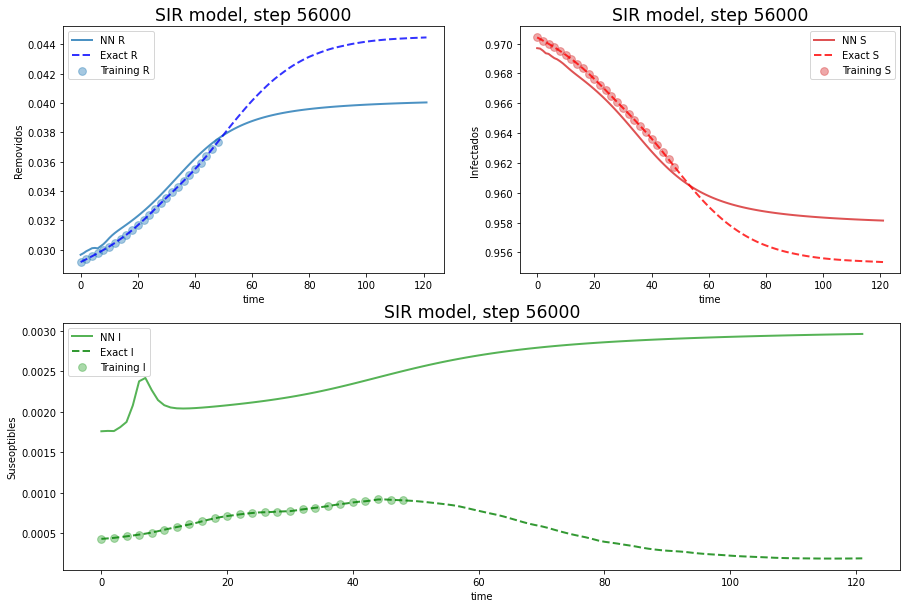

step = 56000 , loss1 = 6.883439e-07 , loss2 = 3.0590865e-08 , loss = 7.1893476e-07 , mse = 4.974757e-06 , beta = 0.047060944 , gamma = 0.04255814
step = 57000 , loss1 = 2.9836666e-08 , loss2 = 2.3446251e-08 , loss = 5.3282918e-08 , mse = 4.885793e-06 , beta = 0.027522612 , gamma = 0.023123076
step = 58000 , loss1 = 1.4653519e-08 , loss2 = 2.9574867e-08 , loss = 4.4228386e-08 , mse = 8.2122e-06 , beta = 0.010315306 , gamma = 0.006087246
step = 59000 , loss1 = 5.39014e-09 , loss2 = 2.3220021e-08 , loss = 2.8610161e-08 , mse = 7.596372e-06 , beta = 0.033132486 , gamma = 0.020081658
step = 60000 , loss1 = 2.61752e-09 , loss2 = 1.7458333e-08 , loss = 2.0075854e-08 , mse = 7.2128432e-06 , beta = 0.06197968 , gamma = 0.041651167
step = 61000 , loss1 = 2.375508e-07 , loss2 = 2.4093989e-08 , loss = 2.6164477e-07 , mse = 5.8417054e-06 , beta = 0.0369228 , gamma = 0.030898148
step = 62000 , loss1 = 1.8233337e-09 , loss2 = 2.0794278e-08 , loss = 2.2617613e-08 , mse = 7.739843e-06 , beta = 0.026903

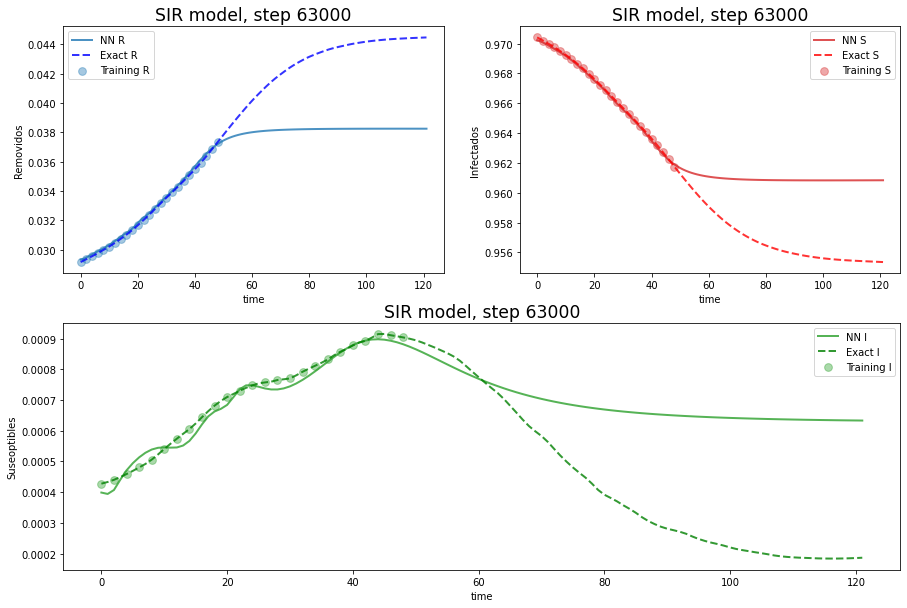

step = 63000 , loss1 = 1.9462565e-08 , loss2 = 1.966906e-08 , loss = 3.9131624e-08 , mse = 8.423335e-06 , beta = 0.025692407 , gamma = 0.02794214
step = 64000 , loss1 = 3.0357248e-09 , loss2 = 1.9549173e-08 , loss = 2.2584898e-08 , mse = 8.005262e-06 , beta = 0.038252182 , gamma = 0.030036045
step = 65000 , loss1 = 7.2019577e-07 , loss2 = 2.2562691e-08 , loss = 7.4275846e-07 , mse = 1.4276413e-05 , beta = -0.018415872 , gamma = -0.0012694736
step = 66000 , loss1 = 7.802741e-07 , loss2 = 3.302041e-08 , loss = 8.132945e-07 , mse = 7.833336e-06 , beta = 0.04672368 , gamma = 0.04367113
step = 67000 , loss1 = 6.1421126e-08 , loss2 = 2.5137002e-08 , loss = 8.655813e-08 , mse = 1.2680601e-05 , beta = 0.0014424926 , gamma = 0.0067751473
step = 68000 , loss1 = 7.909817e-09 , loss2 = 2.0805555e-08 , loss = 2.8715371e-08 , mse = 6.218526e-06 , beta = 0.026021292 , gamma = 0.0345884
step = 69000 , loss1 = 3.6128298e-09 , loss2 = 1.6748324e-08 , loss = 2.0361153e-08 , mse = 4.217668e-06 , beta = 0.

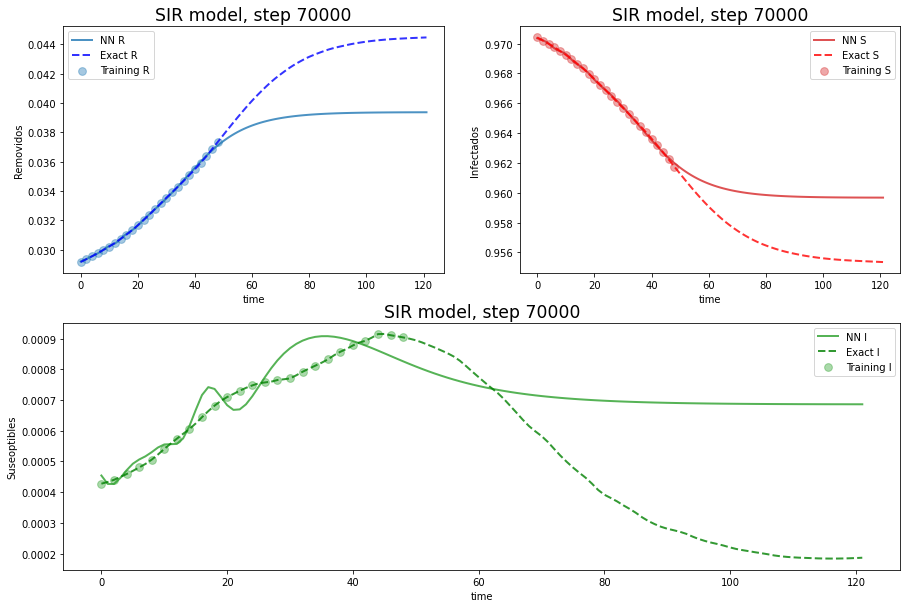

step = 70000 , loss1 = 4.0621284e-09 , loss2 = 1.5011446e-08 , loss = 1.9073575e-08 , mse = 5.366454e-06 , beta = 0.06947628 , gamma = 0.065197736


In [8]:
x_data = Alem_t_train
y_data = Alem_data_train
x = Alem_t
y = Alem_data

# ......................
N = 1.0
torch.manual_seed(123)
modelD = FCND(1,3,42,4)

optimizer = torch.optim.Adam(modelD.parameters(),lr=3e-3)

steps = 70000
print_steps = 500
n_prints = steps // print_steps

Alem_loss1_history = np.zeros(n_prints)
Alem_loss2_history = np.zeros(n_prints)
Alem_loss_history = np.zeros(n_prints)
Alem_mse_history = np.zeros(n_prints)
Alem_beta_history = np.zeros(n_prints)
Alem_gamma_history = np.zeros(n_prints)

x_physics = torch.linspace(0.,Alem['t'].max(),90).view(-1,1).requires_grad_(True)

for i in range(steps):
    #lim= np.minimum(200*i/74000.,200)
    #x_physics = torch.linspace(0.,lim,90).view(-1,1).requires_grad_(True)#
    optimizer.zero_grad()
    
    # compute the "data loss" ..................................................
    yh = modelD(x_data)
    loss1 = 1*torch.mean((yh-y_data)**2)
    
    # compute the "physics loss" with enforcing the initial data ..............
    yhp = modelD(x_physics)
    yhp1= yhp[:,0].view(-1,1)
    yhp2= yhp[:,1].view(-1,1) 
    yhp3= yhp[:,2].view(-1,1)
    
    # compute first and second derivatives by automatic differentiation ....................
    dx1 = torch.autograd.grad(yhp1, x_physics, torch.ones_like(yhp1), create_graph=True)[0]
    dx2 = torch.autograd.grad(yhp2, x_physics, torch.ones_like(yhp2), create_graph=True)[0]
    dx3 = torch.autograd.grad(yhp3, x_physics, torch.ones_like(yhp3), create_graph=True)[0]
    #! aqui quede
    # computes the residual .............................................
    physics2 = (dx1 + (modelD.beta/N)*yhp1*yhp2)                
    physics1 = (dx2 - (modelD.beta/N)*yhp1*yhp2 + modelD.gamma*yhp2)
    physics3 = (dx3 - modelD.gamma*yhp2)
    loss2 = 1*torch.mean((physics1)**2) + 1*torch.mean((physics2)**2) + 1*torch.mean((physics3)**2)
    
    # backpropagate the total loss ...............................................
    loss = loss1 + loss2  # add two loss terms together .....................
    loss.backward()
    optimizer.step()    
        
    # plot the result as training progresses ...............................
    
    if (i+1) % print_steps == 0: 
        i_print = i // print_steps
        Alem_loss1_history[i_print] = loss1.detach().numpy()
        Alem_loss2_history[i_print] = loss2.detach().numpy()
        Alem_loss_history[i_print] = loss.detach().numpy()
        
        yh = modelD(x).detach()
        xp = x_physics.detach()
        
        yhpp=modelD(x)

        mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution .....
        Alem_mse_history[i_print] = mse.detach().numpy()

        Alem_beta_history[i_print] = modelD.beta.detach().numpy()[0]
        Alem_gamma_history[i_print] = modelD.gamma.detach().numpy()[0]

        if (i+1) == 500: plot_result_al(i,x,y,x_data,y_data,yh,xp)
        if (i+1) % 1000 == 0 and (i+1) < 5000: plot_result_al(i,x,y,x_data,y_data,yh,xp)
        if (i+1) % 7000 == 0: plot_result_al(i,x,y,x_data,y_data,yh,xp)
        else: plt.close("all")
    if (i+1) % 1000 == 0: print('step =', i+1, ', loss1 =', loss1.detach().numpy(), ', loss2 =', loss2.detach().numpy(), ', loss =', loss.detach().numpy(),
                                ', mse =', mse.detach().numpy(), ', beta =', modelD.beta.detach().numpy()[0], ', gamma =', modelD.gamma.detach().numpy()[0])


Los mejores valores de beta y gamma son, beta = 0.11173126846551895 , gamma = 0.10394296050071716


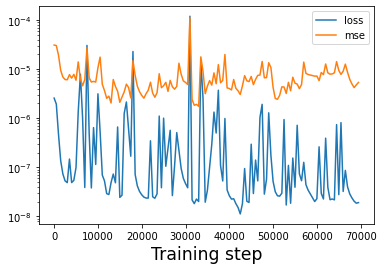

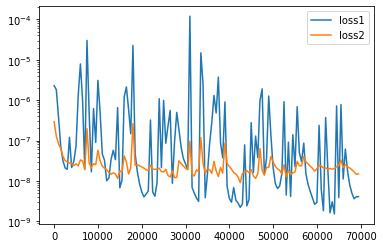

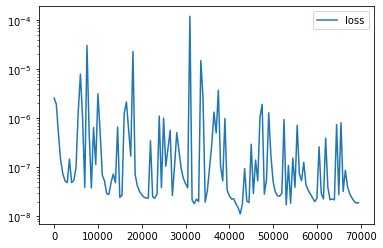

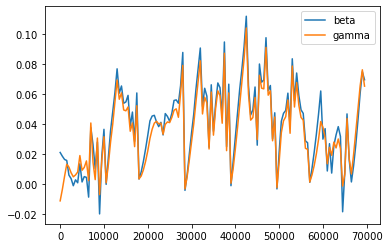

In [9]:
all_steps = np.arange(0, steps, print_steps)

fig33 = plt.figure(33)
plt.plot(all_steps,Alem_loss_history, label="loss")
plt.plot(all_steps,Alem_mse_history, label="mse")
plt.xlabel('Training step',fontsize="xx-large")
plt.yscale('log')
plt.legend()

fig50 = plt.figure(50)
plt.plot(all_steps,Alem_loss1_history, label="loss1")
plt.plot(all_steps,Alem_loss2_history, label="loss2")
plt.yscale('log')
plt.legend()

fig51 = plt.figure(51)
plt.plot(all_steps,Alem_loss_history, label="loss")
plt.yscale('log')
plt.legend()

fig60 = plt.figure(60)
plt.plot(all_steps,Alem_beta_history, label="beta")
plt.plot(all_steps,Alem_gamma_history, label="gamma")
plt.legend()

#find the index of min loss
min_loss_index = np.argmin(Alem_loss_history)
print('Los mejores valores de beta y gamma son, beta =', Alem_beta_history[min_loss_index], ', gamma =', Alem_gamma_history[min_loss_index])

### PINN sin busqueda de parametros

1000 tensor(1.5242e-06) tensor(1.3159e-07) tensor(1.6558e-06) tensor(2.9679e-05, grad_fn=<MeanBackward0>)
2000 tensor(7.0436e-08) tensor(6.3964e-08) tensor(1.3440e-07) tensor(8.8144e-06, grad_fn=<MeanBackward0>)
3000 tensor(1.8044e-06) tensor(4.3250e-08) tensor(1.8477e-06) tensor(7.2191e-06, grad_fn=<MeanBackward0>)
4000 tensor(3.2667e-08) tensor(2.8844e-08) tensor(6.1512e-08) tensor(7.3865e-06, grad_fn=<MeanBackward0>)


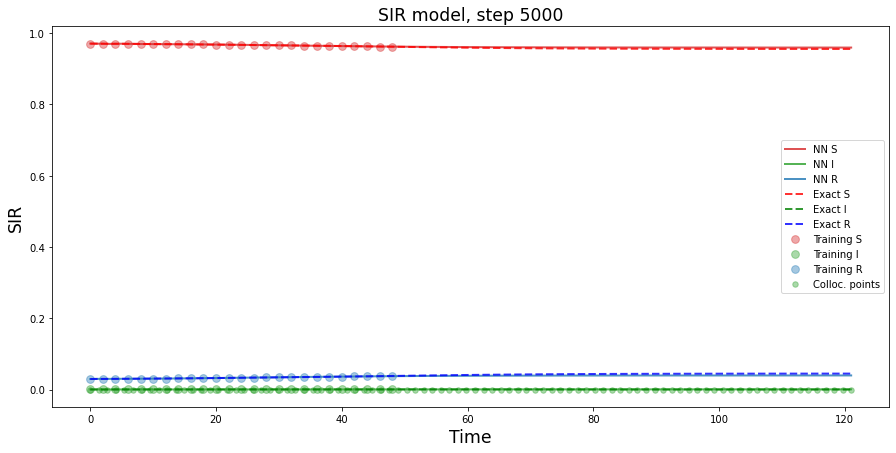

5000 tensor(2.0211e-08) tensor(2.7839e-08) tensor(4.8050e-08) tensor(5.5932e-06, grad_fn=<MeanBackward0>)
6000 tensor(3.3382e-06) tensor(2.8487e-08) tensor(3.3667e-06) tensor(9.3478e-06, grad_fn=<MeanBackward0>)
7000 tensor(1.7940e-08) tensor(2.7677e-08) tensor(4.5617e-08) tensor(4.6969e-06, grad_fn=<MeanBackward0>)
8000 tensor(6.3050e-06) tensor(3.1358e-08) tensor(6.3364e-06) tensor(1.0313e-05, grad_fn=<MeanBackward0>)
9000 tensor(3.5565e-08) tensor(2.6258e-08) tensor(6.1823e-08) tensor(5.3019e-06, grad_fn=<MeanBackward0>)


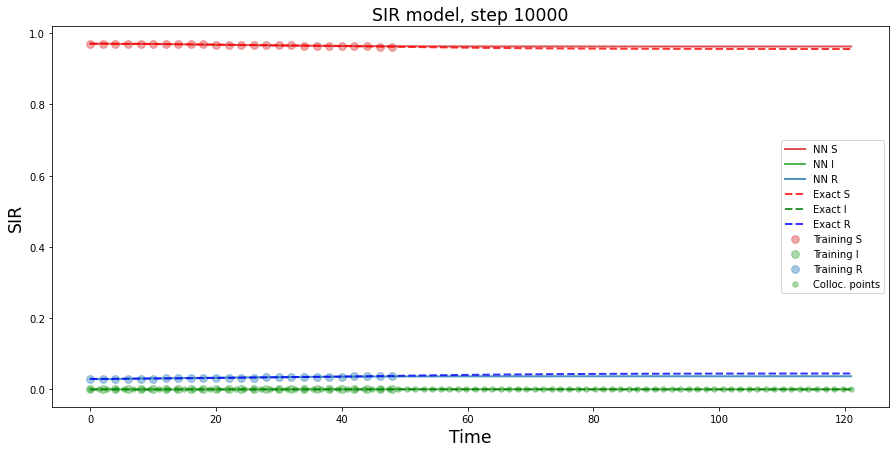

10000 tensor(2.3995e-07) tensor(5.7942e-08) tensor(2.9789e-07) tensor(1.5120e-05, grad_fn=<MeanBackward0>)
11000 tensor(1.2997e-08) tensor(2.7394e-08) tensor(4.0391e-08) tensor(5.0582e-06, grad_fn=<MeanBackward0>)
12000 tensor(6.1835e-09) tensor(2.7851e-08) tensor(3.4035e-08) tensor(3.4874e-06, grad_fn=<MeanBackward0>)
13000 tensor(5.7153e-09) tensor(2.8371e-08) tensor(3.4087e-08) tensor(3.0272e-06, grad_fn=<MeanBackward0>)
14000 tensor(5.2545e-09) tensor(2.8268e-08) tensor(3.3523e-08) tensor(3.0940e-06, grad_fn=<MeanBackward0>)


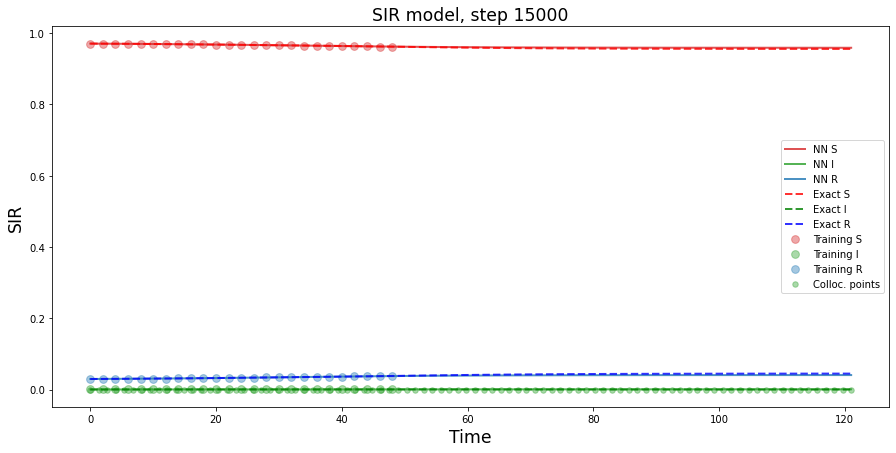

15000 tensor(5.8610e-09) tensor(2.7402e-08) tensor(3.3263e-08) tensor(3.5823e-06, grad_fn=<MeanBackward0>)
16000 tensor(5.8070e-08) tensor(2.6074e-08) tensor(8.4144e-08) tensor(4.5201e-06, grad_fn=<MeanBackward0>)
17000 tensor(1.2764e-07) tensor(2.7000e-08) tensor(1.5464e-07) tensor(3.8446e-06, grad_fn=<MeanBackward0>)
18000 tensor(3.0042e-07) tensor(2.3861e-08) tensor(3.2428e-07) tensor(3.7297e-06, grad_fn=<MeanBackward0>)
19000 tensor(0.0003) tensor(1.9255e-07) tensor(0.0003) tensor(0.0005, grad_fn=<MeanBackward0>)


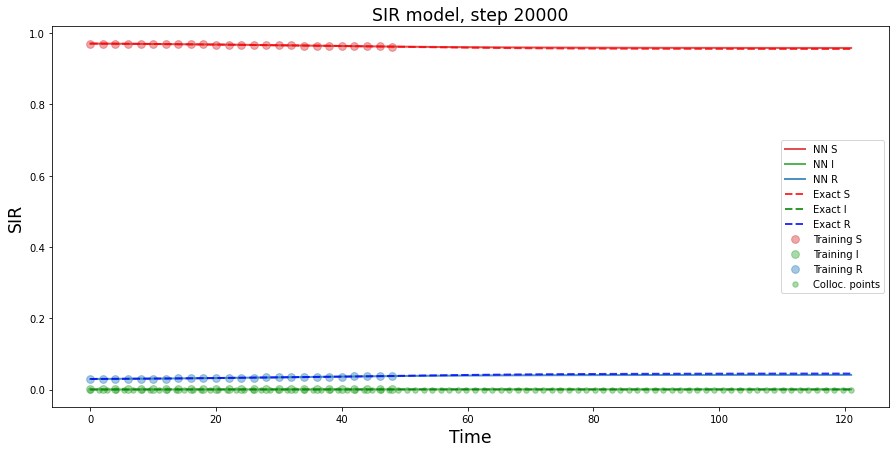

20000 tensor(6.8168e-09) tensor(2.8636e-08) tensor(3.5452e-08) tensor(2.8460e-06, grad_fn=<MeanBackward0>)
21000 tensor(5.2563e-09) tensor(2.8506e-08) tensor(3.3762e-08) tensor(2.7461e-06, grad_fn=<MeanBackward0>)
22000 tensor(7.1310e-09) tensor(2.7069e-08) tensor(3.4200e-08) tensor(3.8575e-06, grad_fn=<MeanBackward0>)
23000 tensor(1.0201e-08) tensor(2.6099e-08) tensor(3.6300e-08) tensor(4.9399e-06, grad_fn=<MeanBackward0>)
24000 tensor(1.6320e-08) tensor(2.6638e-08) tensor(4.2958e-08) tensor(4.6080e-06, grad_fn=<MeanBackward0>)


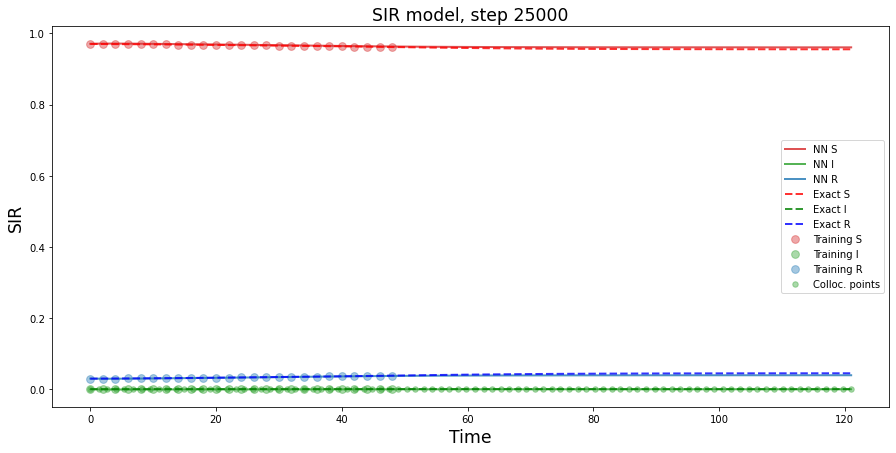

25000 tensor(1.3484e-06) tensor(2.9471e-08) tensor(1.3779e-06) tensor(8.6055e-06, grad_fn=<MeanBackward0>)
26000 tensor(3.6432e-07) tensor(2.9513e-08) tensor(3.9384e-07) tensor(7.1862e-06, grad_fn=<MeanBackward0>)
27000 tensor(2.9497e-06) tensor(1.5792e-08) tensor(2.9655e-06) tensor(1.1660e-05, grad_fn=<MeanBackward0>)
28000 tensor(7.5807e-07) tensor(3.4359e-08) tensor(7.9243e-07) tensor(5.6618e-06, grad_fn=<MeanBackward0>)
29000 tensor(3.8052e-07) tensor(3.3479e-08) tensor(4.1400e-07) tensor(1.9943e-05, grad_fn=<MeanBackward0>)


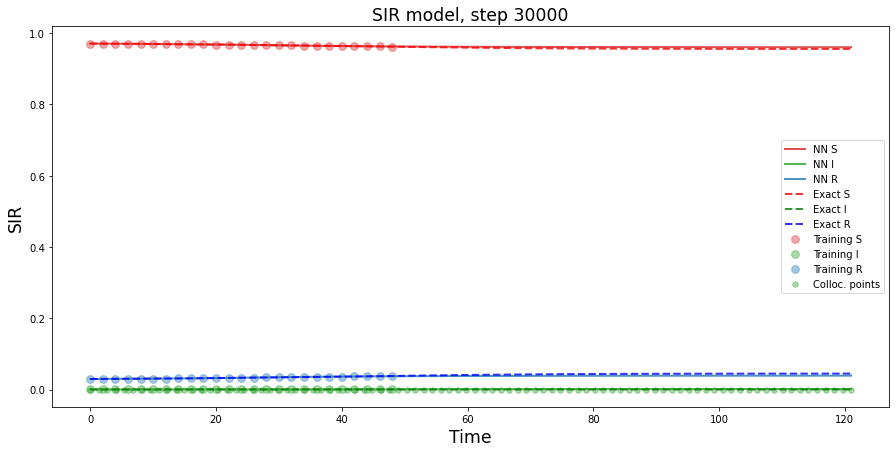

30000 tensor(4.9445e-08) tensor(2.4033e-08) tensor(7.3478e-08) tensor(8.2709e-06, grad_fn=<MeanBackward0>)
31000 tensor(5.7317e-08) tensor(2.5563e-08) tensor(8.2880e-08) tensor(9.2686e-06, grad_fn=<MeanBackward0>)
32000 tensor(1.7048e-08) tensor(2.4490e-08) tensor(4.1538e-08) tensor(7.0174e-06, grad_fn=<MeanBackward0>)
33000 tensor(1.3817e-08) tensor(2.5701e-08) tensor(3.9518e-08) tensor(4.7844e-06, grad_fn=<MeanBackward0>)
34000 tensor(5.9122e-09) tensor(2.5992e-08) tensor(3.1904e-08) tensor(4.8330e-06, grad_fn=<MeanBackward0>)


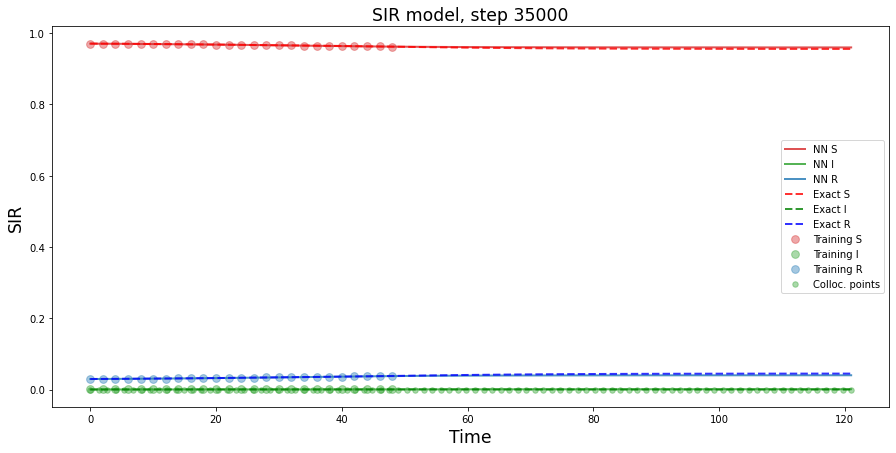

35000 tensor(3.1623e-08) tensor(2.5905e-08) tensor(5.7528e-08) tensor(5.2297e-06, grad_fn=<MeanBackward0>)
36000 tensor(7.1491e-07) tensor(3.0100e-08) tensor(7.4501e-07) tensor(3.3441e-06, grad_fn=<MeanBackward0>)
37000 tensor(3.6187e-07) tensor(2.1384e-08) tensor(3.8326e-07) tensor(5.1437e-06, grad_fn=<MeanBackward0>)
38000 tensor(1.0457e-08) tensor(2.7573e-08) tensor(3.8031e-08) tensor(5.1723e-06, grad_fn=<MeanBackward0>)
39000 tensor(4.3740e-09) tensor(2.7942e-08) tensor(3.2316e-08) tensor(3.9065e-06, grad_fn=<MeanBackward0>)


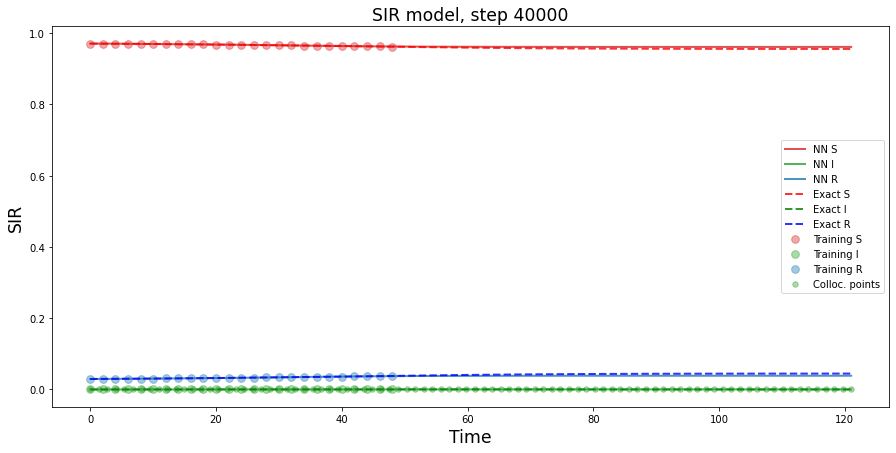

40000 tensor(1.9792e-08) tensor(2.3874e-08) tensor(4.3666e-08) tensor(8.8457e-06, grad_fn=<MeanBackward0>)
41000 tensor(5.6436e-06) tensor(5.3573e-08) tensor(5.6972e-06) tensor(9.2912e-06, grad_fn=<MeanBackward0>)
42000 tensor(2.9372e-06) tensor(2.2679e-08) tensor(2.9598e-06) tensor(1.2510e-05, grad_fn=<MeanBackward0>)
43000 tensor(5.2493e-07) tensor(2.4560e-08) tensor(5.4949e-07) tensor(4.9419e-06, grad_fn=<MeanBackward0>)
44000 tensor(6.6262e-09) tensor(2.5955e-08) tensor(3.2581e-08) tensor(5.1063e-06, grad_fn=<MeanBackward0>)


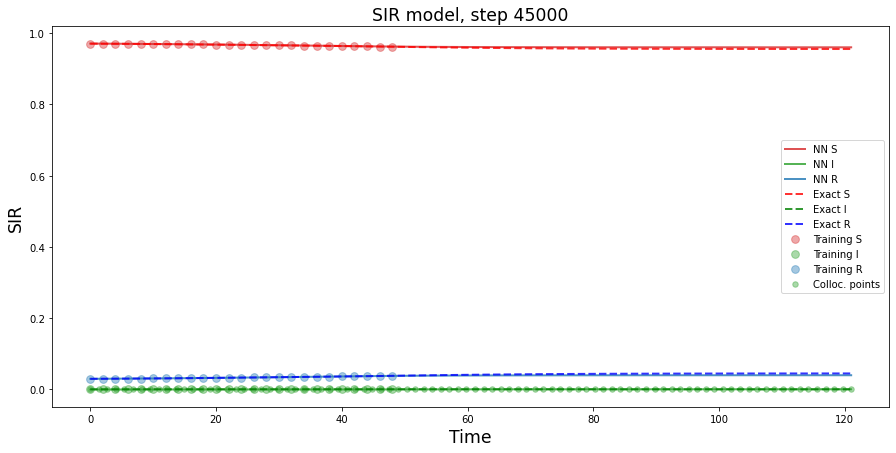

45000 tensor(1.5428e-07) tensor(2.3238e-08) tensor(1.7752e-07) tensor(6.1455e-06, grad_fn=<MeanBackward0>)
46000 tensor(1.3877e-07) tensor(2.2687e-08) tensor(1.6146e-07) tensor(6.4079e-06, grad_fn=<MeanBackward0>)
47000 tensor(7.4274e-08) tensor(5.1206e-08) tensor(1.2548e-07) tensor(4.3955e-06, grad_fn=<MeanBackward0>)
48000 tensor(8.3026e-09) tensor(3.1319e-08) tensor(3.9621e-08) tensor(1.6983e-06, grad_fn=<MeanBackward0>)
49000 tensor(5.1096e-09) tensor(2.8456e-08) tensor(3.3566e-08) tensor(2.4049e-06, grad_fn=<MeanBackward0>)


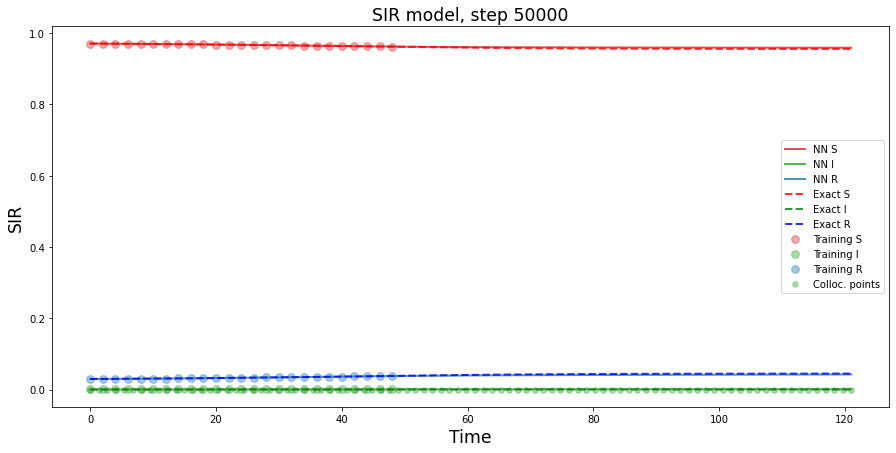

50000 tensor(4.6548e-09) tensor(2.7621e-08) tensor(3.2276e-08) tensor(3.0672e-06, grad_fn=<MeanBackward0>)


In [31]:
x_data = Alem_t_train
y_data = Alem_data_train
x = Alem_t
y = Alem_data

# ......................
ww=1.0
N = 1.0
beta = Alem_beta_history[min_loss_index]
gamma = Alem_gamma_history[min_loss_index]
torch.manual_seed(123)
model = FCN(1,3,42,4)

optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
files = []
loss1_history = []
loss2_history = []
loss_history = []
mse_history = []

x_physics = torch.linspace(0.,Alem['t'].max(),90).view(-1,1).requires_grad_(True)

for i in range(50000):
    #lim= np.minimum(200*i/74000.,200)
    #x_physics = torch.linspace(0.,lim,90).view(-1,1).requires_grad_(True)#
    optimizer.zero_grad()
    
    # compute the "data loss" ..................................................
    yh = model(x_data)
    loss1 = 1*torch.mean((yh-y_data)**2)
    
    # compute the "physics loss" with enforcing the initial data ..............
    yhp = model(x_physics)
    yhp1= yhp[:,0].view(-1,1)
    yhp2= yhp[:,1].view(-1,1) 
    yhp3= yhp[:,2].view(-1,1)
    
    # compute first and second derivatives by automatic differentiation ....................
    dx1 = torch.autograd.grad(yhp1, x_physics, torch.ones_like(yhp1), create_graph=True)[0]
    dx2 = torch.autograd.grad(yhp2, x_physics, torch.ones_like(yhp2), create_graph=True)[0]
    dx3 = torch.autograd.grad(yhp3, x_physics, torch.ones_like(yhp3), create_graph=True)[0]
    #! aqui quede
    # computes the residual .............................................
    physics2 = (dx1 + beta/N*yhp1*yhp2)                
    physics1 = (dx2 - beta/N*yhp1*yhp2 + gamma*yhp2)
    physics3 = (dx3 - gamma*yhp2)
    loss2 = 1*torch.mean((physics1)**2) + 1*torch.mean((physics2)**2) + 1*torch.mean((physics3)**2)
    
    # backpropagate the total loss ...............................................
    loss = loss1 + loss2  # add two loss terms together .....................
    loss.backward()
    optimizer.step()    
        
    # plot the result as training progresses ...............................
    
    if (i+1) % 500 == 0: 
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss_history.append(loss.detach())
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        yhpp=model(x)
        mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution .....
        mse_history.append(mse.detach())

        #if (i+1) == 500: plot_result(i,x,y,x_data,y_data,yh,xp)
        #if (i+1) % 1000 == 0 and (i+1) < 5000: plot_result(i,x,y,x_data,y_data,yh,xp)
        if (i+1) % 5000 == 0: plot_result_al(i,x,y,x_data,y_data,yh,xp)
        else: plt.close("all")
    if (i+1) % 1000 == 0: print(i+1, loss1.detach(), loss2.detach(), loss.detach(), mse)
    

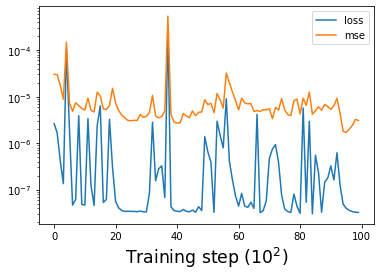

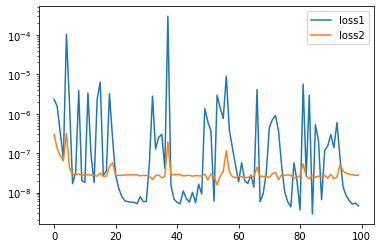

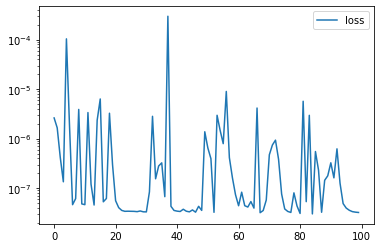

In [32]:
fig33 = plt.figure(33)
plt.plot(loss_history, label="loss")
plt.plot(mse_history, label="mse")
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.yscale('log')
plt.legend()

fig50 = plt.figure(50)
plt.plot(loss1_history, label="loss1")
plt.plot(loss2_history, label="loss2")
plt.yscale('log')
plt.legend()

fig51 = plt.figure(51)
plt.plot(loss_history, label="loss")
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'SIR model, step 50000')

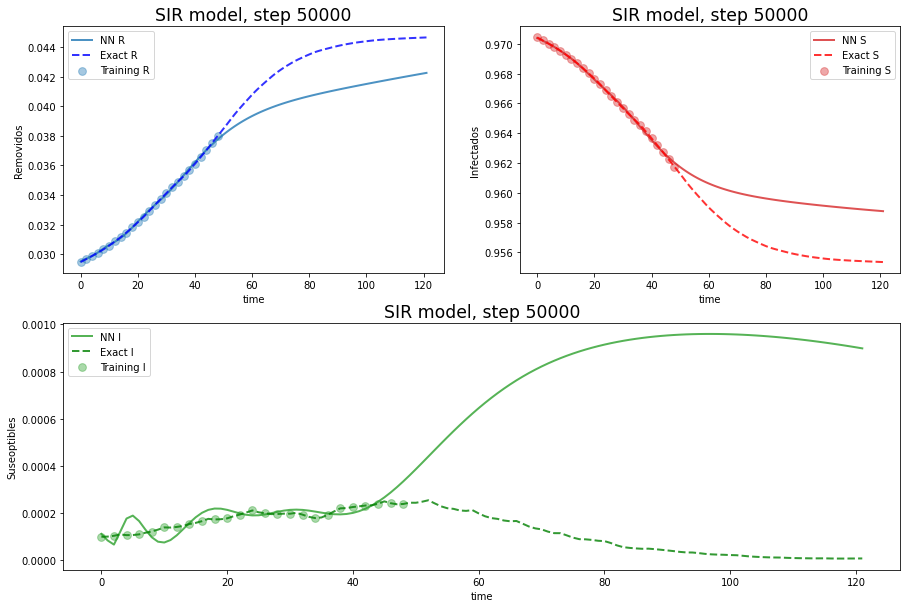

# NN clasica

1000 2.082641458400758e-06
2000 0.0001104842740460299
3000 1.575122610120161e-06
4000 3.5584307624958456e-05
5000 8.087192691164091e-05


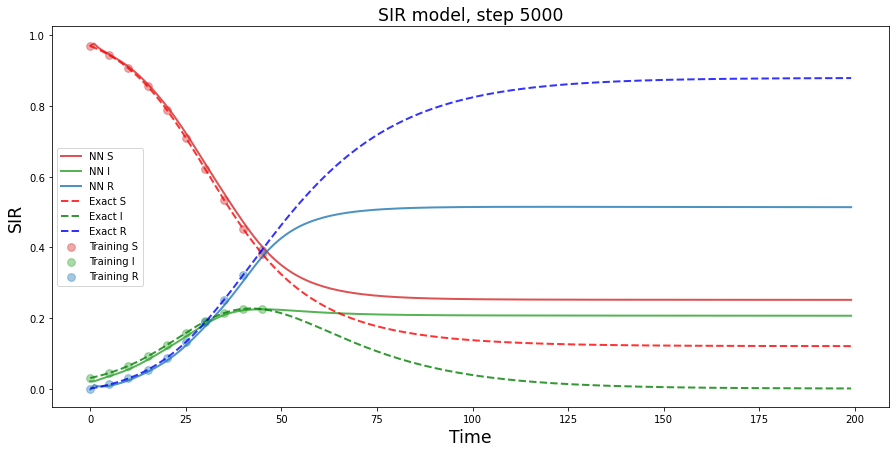

6000 3.1179877169051906e-06
7000 0.00012464335304684937
8000 2.0567553292494267e-05
9000 2.5492471422694507e-07
10000 3.8415257108681544e-07


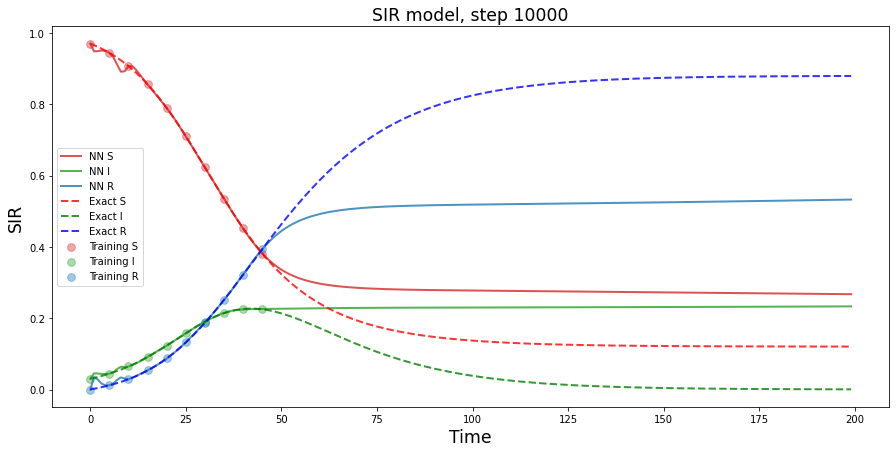

11000 1.1563645784917753e-05
12000 9.325870450993534e-06
13000 0.00032683712197467685
14000 1.952603042809642e-06
15000 3.948680671328475e-07


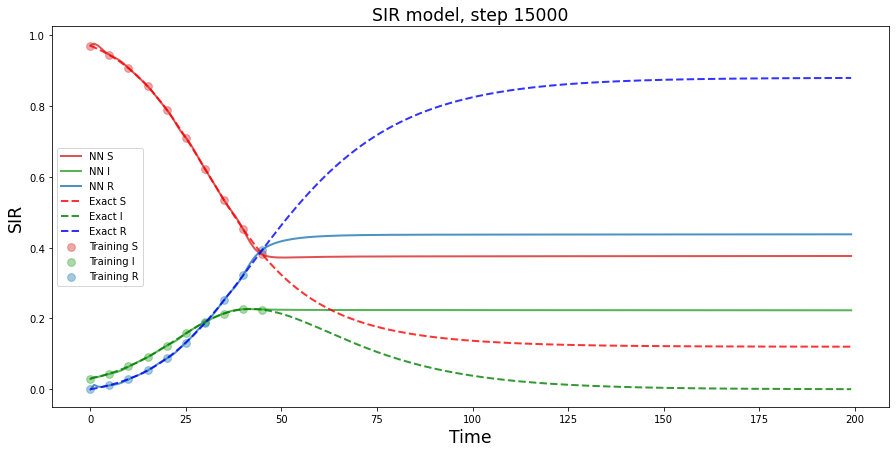

In [28]:
x_data = sim_t_train
y_data = sim_data_train
x = sim_t
y = sim_data

# We train a standard neural network to fit training data (one must choos lr and number of
# layers, number of neurons per layer) ....................................................
torch.manual_seed(127)
model = FCN(1,3,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
files = []
for i in range(15000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error to define Loss on data ......
    loss.backward()
    optimizer.step()
        
    # plot the result as training progresses ..............................................
    if (i+1) % 1000 == 0: print(i+1,loss.item())
    if (i+1) % 100 == 0:         
        yh = model(x).detach()       
        #plot_result(i,x,y,x_data,y_data,yh)   
        if (i+1) % 5000 == 0: plot_result(i,x,y,x_data,y_data,yh) 
        else: plt.close("all")
            